In [28]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Remove future warnings for Pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import the necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import *
import category_encoders as ce
from sklearn.preprocessing import *
## from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.compose import TransformedTargetRegressor

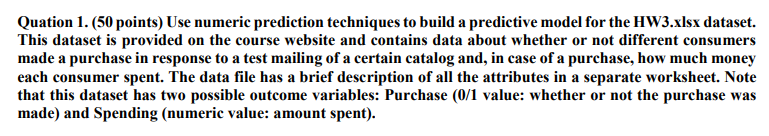

## Dictionary

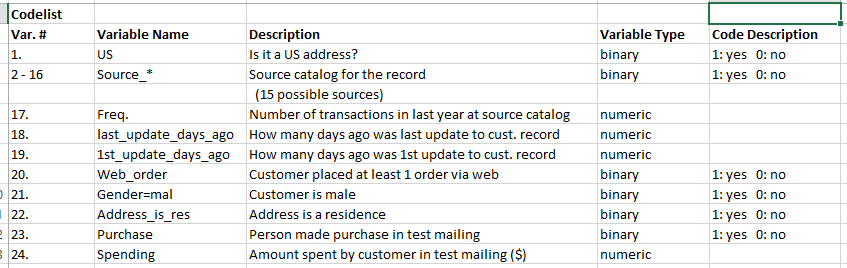

# A. Data pre-processing and pre-analysis

1.  Read in the data
2.  Explore the features and target variables to assess what parameters will need to be changed
3.  Prepare & transform data for data mining process

In [3]:
## Read in the data

purchases_df = pd.read_excel("HW3.xlsx")

In [4]:
## Observe the first five values to make sure data was read in correctly

purchases_df.head()

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,127.87
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0.00
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127.48
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0.00
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0.00


In [5]:
## Run summary statistics on every column except for the "Source", "Last Update", "First Update" columns
## Just to check for missing values

## Create a list of the columns we want to subset
summary_columns = ['US', 'Freq', 'Web order', 'Gender=male', 
                   'Address_is_res', 'Purchase', 'Spending']

purchases_df[summary_columns].describe()

,US,Freq,Web order,Gender=male,Address_is_res,Purchase,Spending
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.824500,1.417000,0.426000,0.524500,0.221000,0.500000,102.560745
std,0.380489,1.405738,0.494617,0.499524,0.415024,0.500125,186.749816
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,0.500000,1.855000
75%,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,152.532500
max,1.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1500.060000


In [6]:
## We check to see what our "target" variable is - Purchase
## It looks like it is a binary classification problem.
## Since we're using numeric prediction, we can leave this the same

purchases_df.Purchase.unique()

array([1, 0], dtype=int64)

In [7]:
## View splits for the targets

total_obvs = purchases_df.groupby("Purchase")["US"].count().sum()
total_purchases = purchases_df.groupby("Purchase")["US"].count()[0]
total_nopurchase = purchases_df.groupby("Purchase")["US"].count()[1]

## Evenly distributed right in the middle
print("{} total customers purchased, \
     {} % of overall observations".format(total_purchases, round(total_purchases/total_obvs*100, 2)))
print("{} total customers did not purchase, \
     {} % of overall observations".format(total_nopurchase, round(total_nopurchase/total_obvs*100, 2)))

1000 total customers purchased,      50.0 % of overall observations
1000 total customers did not purchase,      50.0 % of overall observations


## We see an even split of the data.  I don't see a need to stratify in this instance because of the split of the information.  If they were skewed one way or the other then it might be needed.

## Let's start building our models!

In [10]:
## Remove any columns that will not be used as features
## I am making a conscious decision to remove sequence_number - I believe it is extraneous and not needed
## It won't help the predictive power of the models

feature_cols = purchases_df.columns[~purchases_df.columns.isin(["sequence_number", "Purchase", "Spending"])]
feature_cols

Index(['US', 'source_a', 'source_c', 'source_b', 'source_d', 'source_e',
       'source_m', 'source_o', 'source_h', 'source_r', 'source_s', 'source_t',
       'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web order',
       'Gender=male', 'Address_is_res'],
      dtype='object')

In [11]:
## Create our "X" variable that contains all the features we are curious about plotting
X = np.array(purchases_df[feature_cols])

## Create our "y" variable which is our target variable
y = np.array(purchases_df["Spending"])

## Split data training 70 % and testing 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## First thing I will do is assess which features are actually needed.  To do this, I will use both a Principle Component Analysis, along with a Feature Importance Plot.

C:\Python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


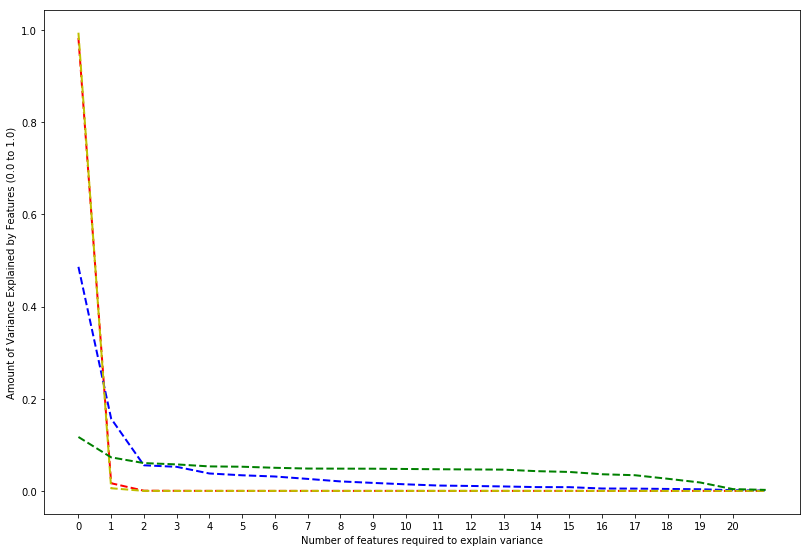

In [13]:
## We normalize our training and testing data PCA to work correctly
## We don't want to skew the results of the plot because some features are not on the same scale
## We perform this normalization AFTER splitting the data - again, so that we don't skew the training
## data with the testing data.

## Normalization is the process of scaling individual samples to have unit norm. This process can be useful 
## if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples.
X_train_norm = Normalizer(norm = "l1").fit_transform(X_train)
X_train_robust = RobustScaler().fit_transform(X_train)
X_train_power = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X_train)
X_train_standard = StandardScaler().fit_transform(X_train)

## Import PCA from sklearn
from sklearn.decomposition import PCA

## Initialize two new PCA instances, we'll use this to plot the training data using two different transformations
## Normalizer will likely be skewed by the outliers in each of the features being used
## Robust is going to transform feature values to be larger than the previous scalers and more importantly are approximately similar to original data
## PowerTransformer is a family of parametric, monotonic transformations that aim to map data from any distribution to as close to a Gaussian distribution 
## as possible in order to stabilize variance and minimize skewness.

pca = PCA()
pca_r = PCA()
pca_p = PCA()
pca_s = PCA()

## The goal of this plot is to determine what features need to be included in our models
## In the first few homeworks, we threw the kitchen sink at the models.  Here, we are going to be
## more refined in our analysis.

## Train the PCA instance using the normalized training data
pca.fit(X_train_norm)
pca_r.fit(X_train_robust)
pca_p.fit(X_train_power)
pca_s.fit(X_train_standard)

plt.figure(1, figsize=(15, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])

plt.plot(pca.explained_variance_ratio_, 'r--', linewidth = 2)
plt.plot(pca_r.explained_variance_ratio_, 'b--', linewidth = 2)
plt.plot(pca_p.explained_variance_ratio_, 'y--', linewidth = 2)
plt.plot(pca_s.explained_variance_ratio_, 'g--', linewidth = 2)

## Set plot labels
plt.xlabel('Number of features required to explain variance')
plt.ylabel('Amount of Variance Explained by Features (0.0 to 1.0)')

## Explicitly set the x-axis data so we can see where the drop-off is
plt.xticks(np.arange(0, 21, step=1))

## Show the graph!
plt.show()

## We only need three features at most, based on this principal component analysis.

## Now let's see which features are the ones that actually explain the most variance.

Feature ranking:
1. feature 16 (0.549566)
2. feature 17 (0.169993)
3. feature 18 (0.114418)
4. feature 21 (0.036042)
5. feature 9 (0.021158)


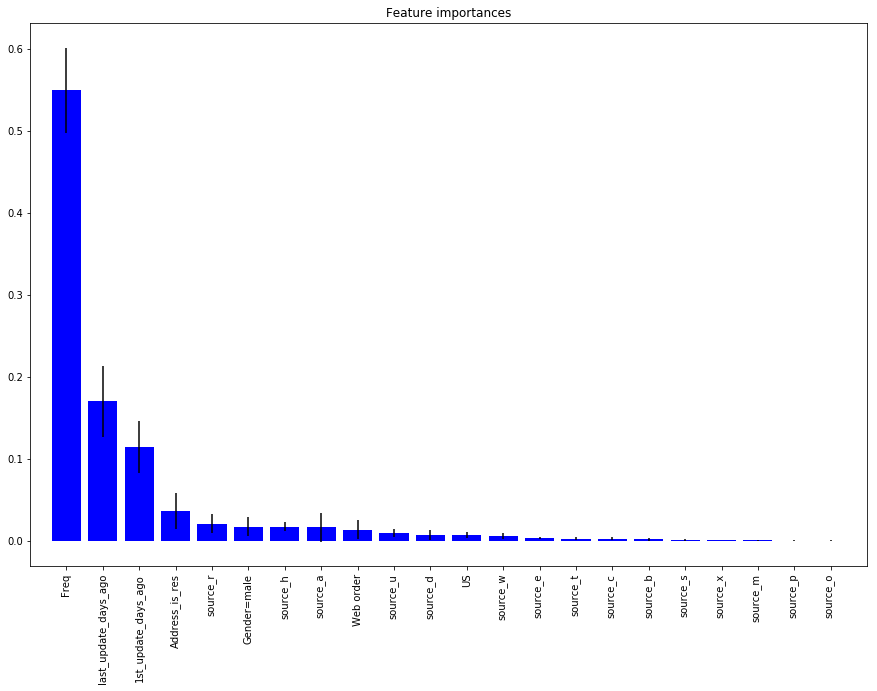

In [14]:
## SET A VARIABLE TO SWAP IN AND OUT BETWEEN THE DIFFERENT TRAINING INSTANCES

#Z = X_train_robust
#Z = X_train_norm
#Z = X_train_power
Z = X_train_standard

## Start with identifying the best features using a Random Forest classifier

## Create a new classifier
clf_rf_5 = ensemble.RandomForestRegressor()      
clr_rf_5 = clf_rf_5.fit(Z, y_train)

## Save our importances to a variable
importances = clr_rf_5.feature_importances_

## Get the standard deviation for each feature
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

## Print the feature ranking
print("Feature ranking:")

## Print the top five features, and their importance based on the Random Forest Classifier
for f in range(0, 5):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


## Plot the feature importances of the Random Forest Regressor - to see this visually

## Set the plot size
plt.figure(1, figsize=(15, 10))

## Set the title
plt.title("Feature importances")

## Plot a graph using all of the normalized features
plt.bar(range(Z.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")

plt.xticks(range(Z.shape[1]), feature_cols[indices], rotation=90)
plt.xlim([-1, Z.shape[1]])

## Show the graph!
plt.show()

## Confirming my earlier observation, only three of the features explain 82% of the variance between all the features.

In [15]:
### Build a custom function to transform feature column or input into a scaled and then labeled item
def robustscale_labelencoder(array):
    
    ## Initialize a RobustScaler object
    rs = RobustScaler()
    ## Initialize a LabelEncoder object
    le = LabelEncoder()
    
    ## Reshape the array to conform to the right dimensions needed for RobustScaler
    array = array.reshape(-1, 1)
    
    ## Transform array using Robust Scaling
    robust_array = rs.fit_transform(array)
    
    ## Reshape the array back to its original shape for Label Encoding
    robust_array = robust_array.flatten()
    
    ## Now apply the LabelEncoding on a better scaled version of the data
    labeled_array = le.fit_transform(robust_array)
    
    ## Return the output
    return labeled_array

In [18]:
## Use that cool function to transform the training target for use in the LR Classifier to observe what 
## features are important
# y_train_robust_labeled = robustscale_labelencoder(y_train)

## Use StandardScaling on the training target.  Not likely to help with training the model, from what I have seen
## in previous attempts to train the models

y_train_standard = StandardScaler().fit_transform(y_train.reshape(-1, 1))

y_train_labeled = LabelEncoder().fit_transform(y_train)

In [20]:
## Build RF classifier to use in feature selection
clf = linear_model.LogisticRegression(C=1e5)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=6,
           forward=True, # Otherwise, this will be the backward selection 
           floating=False,
           n_jobs=10, # The number of CPUs to use for evaluating 
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train_standard, y_train_labeled)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  15 out of  22 | elapsed:   54.2s remaining:   25.2s
[Parallel(n_jobs=10)]: Done  22 out of  22 | elapsed:   58.7s finished

[2019-10-30 14:17:06] Features: 1/6 -- score: 0.44553618151441493[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  13 out of  21 | elapsed:  1.2min remaining:   42.4s
[Parallel(n_jobs=10)]: Done  21 out of  21 | elapsed:  1.2min finished

[2019-10-30 14:18:22] Features: 2/6 -- score: 0.47563816778106094[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:  1.4min remaining:   56.2s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.5min finished

[2019-10-30 14:19:50] Features: 3/6 -- score: 0.5165274559056995[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  10 out of 

In [21]:
## Now we print out what feature columns of Linear Regressor picked out - we can use these to subset later
## We'll remember to grab these columns further along in the analysis
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[3, 7, 8, 16, 17, 21]


## We do a little visual exploration of the features to see what the model is using for data points; this will help us with encoding the target correctly, as well as selecting the proper distance metric for kNN and the various forms of regression.

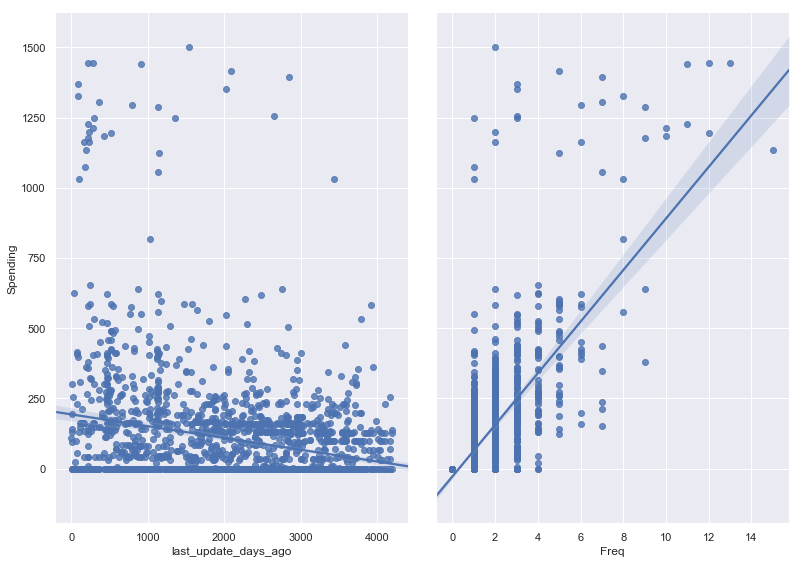

In [22]:
### Reset seaborn to the default background - for better viewing
sns.set()

## Build a quick plot comparing two of the features column with our spending using a simple regression line
sns.pairplot(purchases_df, x_vars=['last_update_days_ago', 'Freq'], y_vars='Spending', height = 8, aspect = 0.7, kind = 'reg')

## Show the plot
plt.show()

## Interesting observation to be made here - the "last update" feature column has a tremendous amount of spread between how much a customer spent, and shows almost no linear relationship at all.

## Conversely, the "freq" feature column is a little bit more linear, but not quite.  So this is telling me that my linear model is probably going to suffer because it won't be able to distinguish between targets very well.

## I will have to scale the features and targets correctly, or many of the data mining models will perform badly.

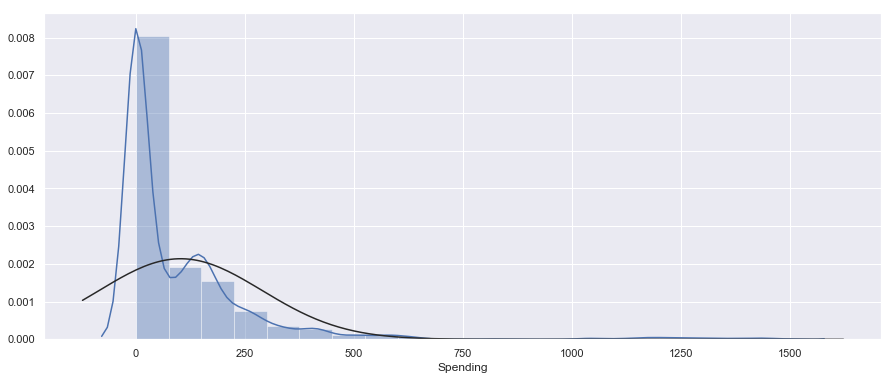

In [23]:
## Plotting out the distribution of spending - to see how much a spread my target is

## Import a normal distribution from scipy
from scipy.stats import norm

## Build a new plot
plt.figure(1, figsize=(15, 6))

## Use a special function in seaborn to build a distribution plot and also include a 
sns.distplot(purchases_df.Spending, fit = norm, kde = True, bins = 20)

## Show the plot
plt.show()

## Most of the spending is less than $20!  We will probably want to standardize/normalize the target first, and then use that as the prediction.

In [25]:
## Create two new encoders for the target - we'll use this to see 
rs = RobustScaler()
pt = PowerTransformer(method='yeo-johnson', standardize=False)
le = LabelEncoder()
nm = Normalizer(norm = "l1")


## Reshape the data because these scaling methods are only supposed to be used by 2D arrays 
y_train_reshape = y_train.reshape(-1, 1)

## Create four versions of the training data, to see the distributions for each one
robust_target = rs.fit_transform(y_train_reshape)
power_target = pt.fit_transform(y_train_reshape)
label_target = le.fit_transform(y_train)
normal_target = nm.fit_transform(y_train_reshape)

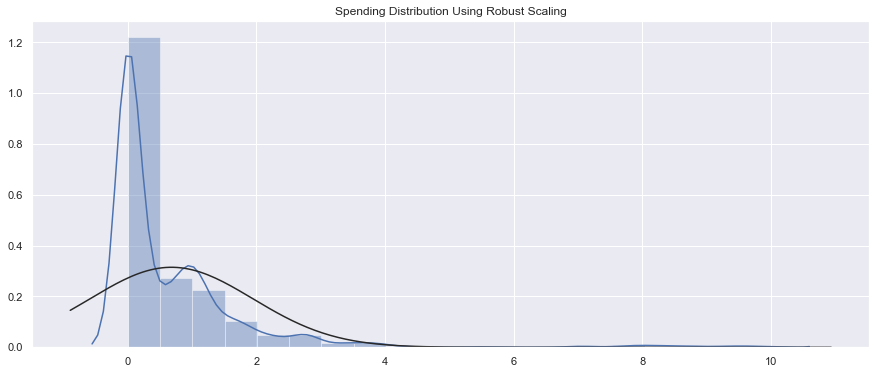

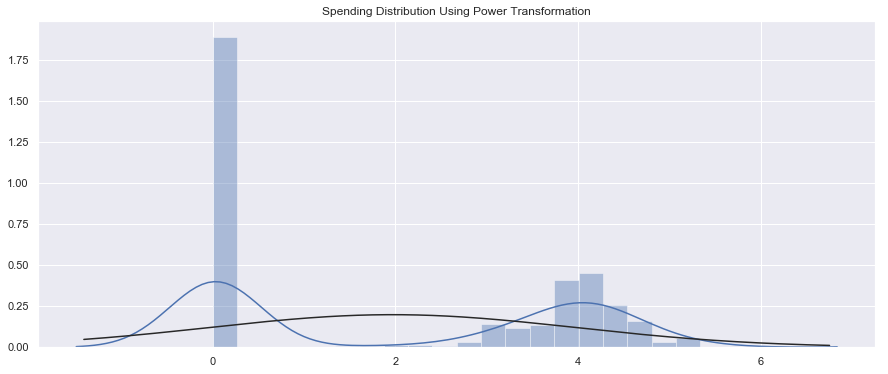

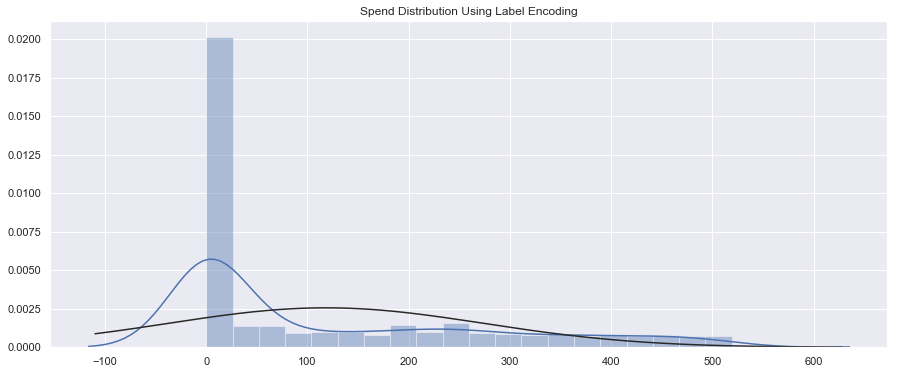

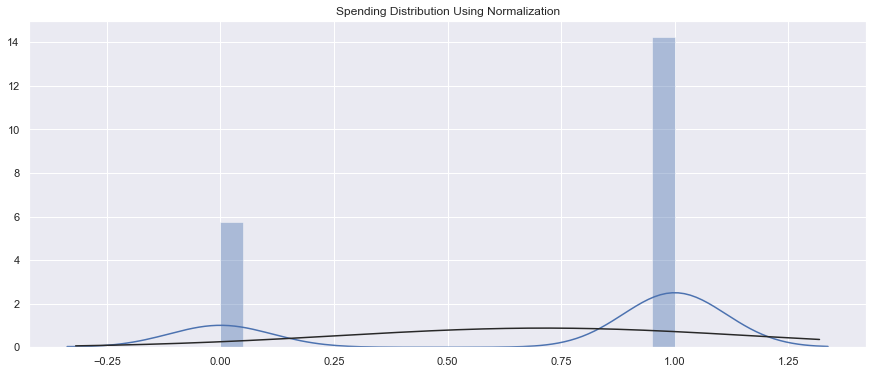

In [26]:
## Plotting out the distribution of spending using the new target variables with new encoding

target_list = [robust_target, power_target, label_target, normal_target]
titles = ["Spending Distribution Using Robust Scaling", "Spending Distribution Using Power Transformation", 
          "Spend Distribution Using Label Encoding", "Spending Distribution Using Normalization"]

for i,t in zip(target_list, titles):
    
# Build a new plot
    plt.figure(1, figsize=(15, 6))

    ## Use a special function in seaborn to build a distribution plot and also include a 
    sns.distplot(i, fit = norm, kde = True, bins = 20)

    plt.title(t)

    ## Show the plot
    plt.show()

## Here's a analysis of the behavior of the different encoding strategies for the target variable.  Based on the above distribution patterns, and knowing how the original "Spending" column is distributed, I will use normalize the target variable for training the model.

## What this pre-processing work has told me is that

1. The target variable is heavily skewed to the left side, most purchases are going to be for low amounts of money
2. We will want to normalize the target variable, to get them on the same scale, otherwise the regression will suffer
3. We're dealing with a lot of outliers, especially the cases where the spend is quite large - we will want to use L1 normalization
4. Many of the features are binary variables and don't really account for the variance or spread
5. In fact, many of them are probably not needed.  So we can build models using all the features or a subset

# B. Model Creation and Evaluation

1.  Create parameter grids for each model
2.  Used nested cross validation to determine the best model
3.  Tune the hyper parameters for the best model
4.  Evaluate the models on the testing data

In [40]:
### RE INITIALIZE OUR TARGETS AND THEN TRANSFORM THE LABELS AND TARGET FOR TRAINING

## Create our "X" variable that contains all the features we are curious about plotting
X = np.array(purchases_df[feature_cols])

## Create our "y" variable which is our target variable
y = np.array(purchases_df["Spending"])

## Split data training 70 % and testing 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Normalize the features 
X_train_normal = nm.fit_transform(X_train)

## Reshape y_train (target variable) for normalization technique
y_train_reshaped = y_train.reshape(-1, 1)
y_train_labeled = le.fit_transform(y_train)

## Print the results of the transformation
print(X_train_normal)
print()
print(y_train_labeled)

[[0.00024969 0.         0.00024969 ... 0.         0.00024969 0.        ]
 [0.00020665 0.         0.         ... 0.00020665 0.00020665 0.        ]
 [0.00030516 0.         0.         ... 0.00030516 0.         0.00030516]
 ...
 [0.00039573 0.         0.00039573 ... 0.00039573 0.         0.00039573]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00035625 0.         0.        ]]

[349 190   2 ...   0   0   0]


## Here are the different models I will be using for my analysis of this regression problem

1. Linear Regression (requires all numeric)
2. k-Nearest Neighbors
3. Decision Tree (requires pre-processing)
4. SVM Regression (requires pre-processing of data)
5. Ensemble/Gradient Boost
6. Neural Network (Keras & KerasTuner)

In [36]:
######### SETTING UP PARAMETER GRIDS FOR THE DIFFERENT DATA MINING MODELS WE ARE GOING TO USE ############

## Set up a grid for the Logit Regressor
## Using L1 only, this is a sparse data set.  And this data mining technique is going to suffer anyways
lr_p_grid = {"penalty": ["l1"],
            "C": [1, 5, 10, 50, 1000],
            "solver": ["liblinear"]}

## Set up a grid for kNN Regressor
## Going to use 1-30 neighbors, and two different distance calculations
knnr_p_grid = {"n_neighbors": list(range(1, 31)),
             "weights": ["uniform", "distance"]}

## Set up a grid for the DecisionTree Regressor
dtr_p_grid = {"criterion": ["mse", "mae"],
            "splitter": ["best", "random"],
            "max_features": [4, 6, 10, 15],
            "max_depth": [5, 10, 15]}

## Set up a grid for the Support Vector Regressor
svr_p_grid = {"C": [1, 5, 10, 50, 1000],
              "gamma": [0.0001, 0.0005, 0.001, 0.005],
             "kernel": ["poly", "rbf"]}

## Set up a grid for GBoost
### Use least squares for the regression
gbr_p_grid = {'loss': ['ls'], 
                 'n_estimators': [100, 200, 300, 400, 500], 
                 'max_depth': [3, 4, 5],
                 'min_samples_split': [2, 4, 6], 
                 'learning_rate': [0.01]}

In [37]:
## Set a number of trials to run for the models

num_trials = 20

## Empty arrays to store scores for classifier
nested_scores_lr = np.zeros(num_trials)
nested_scores_knnr = np.zeros(num_trials)
nested_scores_dtr = np.zeros(num_trials)
nested_scores_svr = np.zeros(num_trials)
nested_scores_gbr = np.zeros(num_trials)

In [38]:
## Create new regressors for each data mining technique

## Linear Regression
lr = linear_model.LogisticRegression()

## k-Nearest Neighbors
knnr = neighbors.KNeighborsRegressor()

## Decision Tree
dtr = tree.DecisionTreeRegressor()

## Support Vector Machine
svr = svm.SVR()

## Gradient Boost
gbr = ensemble.GradientBoostingRegressor()

In [39]:
## All of the new regressors initialized correctly
print(lr, knnr, dtr, svr, gbr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform') DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best') SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False) GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate

## Now we'll use Nested Cross Validation, combined with `GridSearch` to find out what models perform well.

## I am going to build one loop for each regression method to reduce the load on my machine performing this task.

In [52]:
####### Training ground - just to make sure the data is being used well

dtr.fit(X_train_normal, y_train_labeled)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [59]:
## We get a lot of convergence warnings, because the data mining procedures get lost
## I just include this to remove the warnings.

import warnings
warnings.filterwarnings(action = "ignore", module = "sklearn")

In [60]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    lreg= GridSearchCV(estimator=lr, param_grid=lr_p_grid, cv=inner_cv)
    lreg.fit(X_train_normal, y_train_labeled)
    
    nested_score = cross_val_score(lreg, X = X_train_normal, y = y_train_labeled, cv = outer_cv)
    nested_scores_lr[i] = nested_score.mean()

KeyboardInterrupt: 

In [62]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    knnreg= GridSearchCV(estimator=knnr, param_grid=knnr_p_grid, cv=inner_cv)
    knnreg.fit(X_train_normal, y_train_labeled)
    
    nested_score = cross_val_score(knnreg, X = X_train_normal, y = y_train_labeled, cv = outer_cv)
    nested_scores_knnr[i] = nested_score.mean()

In [64]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    dtreg= GridSearchCV(estimator=dtr, param_grid=dtr_p_grid, cv=inner_cv)
    dtreg.fit(X_train_normal, y_train_labeled)
    
    nested_score = cross_val_score(dtreg, X = X_train_normal, y = y_train_labeled, cv = outer_cv)
    nested_scores_dtr[i] = nested_score.mean()

In [67]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logistic Regression
    
    svreg= GridSearchCV(estimator=svr, param_grid=svr_p_grid, cv=inner_cv)
    svreg.fit(X_train_normal, y_train_labeled)
    
    nested_score = cross_val_score(svreg, X = X_train_normal, y = y_train_labeled, cv = outer_cv)
    nested_scores_svr[i] = nested_score.mean()

In [70]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    gbreg= GridSearchCV(estimator=gbr, param_grid=gbr_p_grid, cv=inner_cv)
    gbreg.fit(X_train_normal, y_train_labeled)
    
    nested_score = cross_val_score(gbreg, X = X_train_normal, y = y_train_labeled, cv = outer_cv)
    nested_scores_gbr[i] = nested_score.mean()

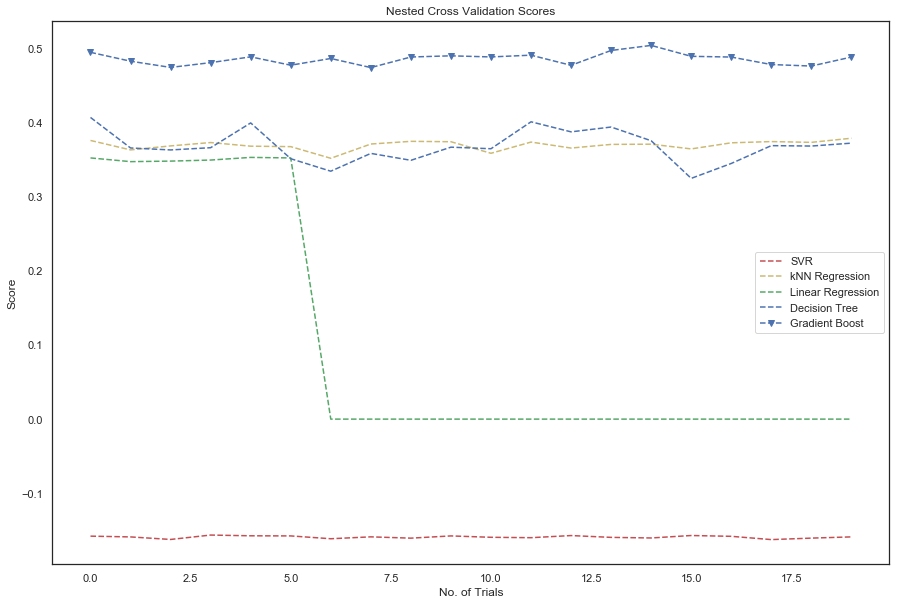

In [263]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(nested_scores_svr, 'r--', label = "SVR")
plt.plot(nested_scores_knnr, 'y--', label = "kNN Regression")
plt.plot(nested_scores_lr, 'g--', label = "Linear Regression")
plt.plot(nested_scores_dtr, 'b--', label = "Decision Tree")
plt.plot(nested_scores_gbr, 'v--', label = "Gradient Boost")


## Give some labels
plt.xlabel("No. of Trials")
plt.ylabel("Score")

## Title and legend
plt.title("Nested Cross Validation Scores")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

## What this plot tells us is our models really suffer and don't do well with multivariate regression, which is what this problem is.  We're going to try using a different method, namely Keras & Tensorflow to build a Neural Network.

## Here we start building a neural network; it allows us to build from the ground up, continually learning, and will hopefully lead to much better performance.

In [18]:
## Import our libraries

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

Using TensorFlow backend.


In [9]:
## Remove any columns that will not be used as features
## I am making a conscious decision to remove sequence_number - I believe it is extraneous and not needed
## It won't help the predictive power of the models

feature_cols = purchases_df.columns[~purchases_df.columns.isin(["sequence_number", "Purchase", "Spending"])]
feature_cols

Index(['US', 'source_a', 'source_c', 'source_b', 'source_d', 'source_e',
       'source_m', 'source_o', 'source_h', 'source_r', 'source_s', 'source_t',
       'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web order',
       'Gender=male', 'Address_is_res'],
      dtype='object')

In [10]:
## Create a new "X" variable that contains all the features we are curious about plotting
X = np.array(purchases_df[feature_cols])

## Create our "y" variable which is our target variable and remove the floating point decimals
y = np.array(purchases_df["Spending"])

## Split data training 70 % and testing 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [11]:
## Standardize dataset
## Create new scaling object

sc = StandardScaler()

## Standardize the training data
X_train_standard = sc.fit_transform(X_train)
y_train_standard = sc.fit_transform(y_train.reshape(len(y_train),1))[:,0]

In [21]:
## Build a new model using Keras, with 22 feature columns

## Rectified Linear Unit - f(x) = max_value for x >= max_value, f(x) = x for threshold <= x < max_value, f(x) = alpha * (x - threshold)
## Initializer - he_uniform - It draws samples from a uniform distribution within [-limit, limit] where limit is sqrt(6 / fan_in) where fan_in is the number of input units in the weight tensor.
model = Sequential()
model.add(Dense(25, input_dim=22, activation='relu', kernel_initializer='he_uniform'))

## Activation - Linear to perform linear regression
model.add(Dense(1, activation='linear'))

In [23]:
## Standardize the testing data separately from the training data

X_test_standard = sc.transform(X_test)
y_test_standard = sc.transform(y_test.reshape(len(y_test),1))[:,0]

In [24]:
## Build the optimizer with stochastic gradient descent with a learning rate of 0.01 and a momentum of 0.9

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss="mean_squared_logarithmic_error", optimizer=opt, metrics = ["mse"])

## fit model
history = model.fit(X_train_standard, y_train_standard,
            validation_data=(X_test_standard, y_test_standard), epochs=100, verbose=0)

In [25]:
## Evaluate the model once it has been fit to determine performance

train_mse = model.evaluate(X_train_standard, y_train_standard, verbose=0)
test_mse = model.evaluate(X_test_standard, y_test_standard, verbose=0)

## The Mean Squared Error, or MSE, loss is the default loss function to use for most regression problems, and this would normally be the logical choice.  It is the preferred loss function under the inference framework of maximum likelihood if the distribution of the target is a Gaussian (normal) distrubtion.

## In this case, it is a regression problem where the target values have a large spread of values, from $0 to 1500, and when predicting a larger value, we do not want to punish the model as heavily as with MSE.

## Instead, we can calculate the natural logarithm of each of the predicted values, <u>then</u> calculate the mean squared error.  This is called the Mean Squared Logarithmic Error loss, or MSLE for short.

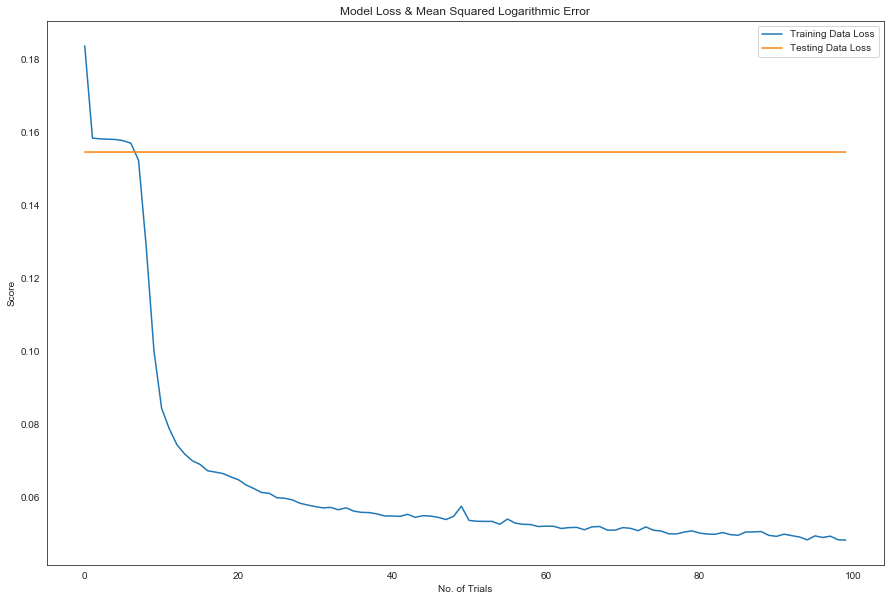

In [26]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(history.history['loss'], label = "Training Data Loss")
plt.plot(history.history['val_loss'], label = "Testing Data Loss")

## Give some labels and title
plt.xlabel("No. of Epochs")
plt.ylabel("Score")

## Title and legend
plt.title("Model Loss & Mean Squared Logarithmic Error")
plt.legend()

## Show the graph
plt.show()

## I created a line plot to show the Mean Squared Logarithmic Error (MSLE) loss over the training cycles on both the training data (blue line) and testing data (orange line).

## We can see that the model learned reasonably quickly (after about 15 epochs) and test performance remained equivalent/steady from the moment the model was created because of the loss function being used.

## The performance and convergence behavior of the model suggests that MSLE is a good match for a neural network model attempting to learn from this problem.

## I will also want to see the Mean Squared Error (MSE) performance of the model, because the logarithmic loss function puts all of our "Purchases" on an expontential scale (the power of 10).  As discovered earlier, most of the purchases are for less than $20.00, so we have to make sure the model can handle identifying smaller amounts.

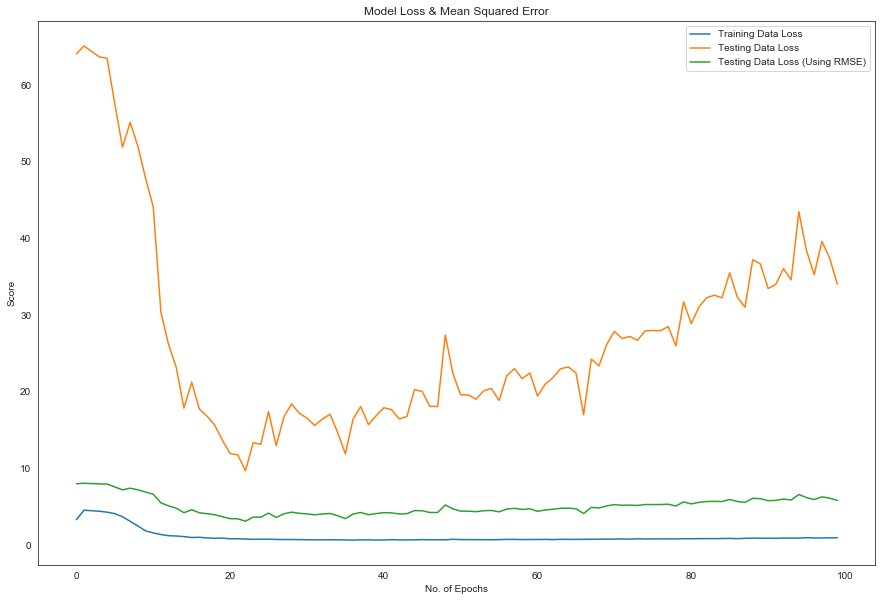

In [28]:
from math import sqrt

### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(history.history['mse'], label = "Training Data Loss")
plt.plot(history.history['val_mse'], label = "Testing Data Loss")

## Add more line for plotting the RMSE of testing data
plt.plot([sqrt(i) for i in history.history['val_mse']], label = "Testing Data Loss (Using RMSE)")

## Give some labels and title
plt.xlabel("No. of Epochs")
plt.ylabel("Score")

## Title and legend
plt.title("Model Loss & Mean Squared Error")
plt.legend()

## Show the graph
plt.show()

## This plot shows the Mean Squared Error loss over the training cycles for training data (blue line) and testing data (orange line); I also created a line to show the <u>Root</u> Mean Squared Error (RMSE) for testing data to really show the model performance.

## It appears that MSE may be showing signs of over-fitting the problem.  When I look at the RMSE, it is much more stable and doesn't fluctuate quite as much when going through training cycles.  While I am confident that this model is performing much better compared to my earlier attempts with the "out-of-box" regressors from `sklearn`, I will run a similar process on the data but remove any rows that did not have a purchase to evaluate the model performance using this method.

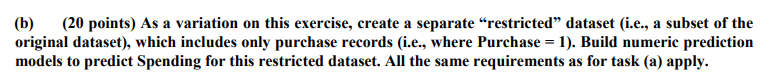

In [29]:
## Create a subset of the data, so that we only try to predict the Spending - cool!

## Subset the dataframe created earlier to only include rows with Spending information
purchase_only_df = purchases_df[purchases_df.Purchase != 0]

In [30]:
## Look at the first five observations

purchase_only_df.head()

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,127.87
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127.48
8,9,1,1,0,0,0,0,0,0,0,...,0,0,4,525,2914,1,1,0,1,488.50
9,10,1,1,0,0,0,0,0,0,0,...,0,0,1,3215,3215,0,0,0,1,173.50
13,14,1,1,0,0,0,0,0,0,0,...,0,0,5,2081,2438,0,1,0,1,1416.00


In [31]:
## Confirm that no records without a purchase made it in

purchase_only_df.groupby("Purchase")["US"].count()

Purchase
1    1000
Name: US, dtype: int64

In [33]:
## Create a new "X" variable that contains all the features
X = np.array(purchase_only_df[feature_cols])

## Create our "y" variable which is our target variable and remove the floating point decimals
y = np.array(purchase_only_df["Spending"])

## Split data training 70 % and testing 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [34]:
## Standardize training features and target variable

sc = StandardScaler()

X_train_standard = sc.fit_transform(X_train)
y_train_standard = sc.fit_transform(y_train.reshape(len(y_train),1))[:,0]

In [35]:
## Standardize testing features and target variable separately so that the training data doesn't skew or affect the model performance
## This is known as DATA LEAKAGE.

X_test_standard = sc.transform(X_test)
y_test_standard = sc.transform(y_test.reshape(len(y_test),1))[:,0]

# C. Use helpful Keras & Keras Tuner libraries to help us perform model evaluation at the same time we develop new classifiers

1.  Build the model function
2.  Build the hyper tuner function
3.  Tune the model and explore the data space to make predictions
4.  Assess the model performance.

## We can use some specific custom functions which are explained below.

In [ ]:
### Import some libraries to help us build and tune the model at the same time

from tensorflow import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers

In [45]:
## As a first step, we build a function to actually put together our model

def build_model(hp):
    
    ## Base layer
    model = Sequential()
    
    ## Add first layer, test with 10 up to 22 features
    model.add(layers.Dense(units = hp.Int ("units", 
                                          min_value = 10,
                                          max_value = 22,
                                          step = 2),
                          ## Use same initializer as model above
                          activation = "relu", kernel_initializer = "he_uniform"))
    
    ## Add target layer using linear regressor
    model.add(layers.Dense(1, activation = "linear"))
    
    ## Use different learning rates to test the model
    model.compile(
    optimizer = keras.optimizers.SGD(
        hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])),
    
    
    ## Use same loss fucntion as before
    loss = "mean_squared_logarithmic_error",
    
    ## Test using MSE
    
    metrics = ["mse"])
    
    ## Return completed model
    return model

In [46]:
## Second step, we build a "hypertuner", this is what will actually fine tune our model as it is being created

### Use RandomSearch

tuner = RandomSearch(

    ## Use model function from above
    build_model,
    
    ## What is objective function?  Using loss here
    objective = "val_loss",
    
    ## Set number of trials
    max_trials = 5,
    
    ## Number of executions
    executions_per_trial = 3,
    
    ## Set to short dir path
    directory = "C:\\"

)

In [47]:
## Run our search with Keras Tuner!

tuner.search(X_train_standard, y_train_standard, epochs = 10,
            validation_data = (X_test_standard, y_test_standard))

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - ETA: 9s - loss: 0.2278 - mse: 2.077 - ETA: 0s - loss: 0.1906 - mse: 1.850 - 1s 1ms/sample - loss: 0.1897 - mse: 1.8145 - val_loss: 0.2142 - val_mse: 39.1103
Epoch 2/10
700/700 [==============================] - ETA: 0s - loss: 0.3552 - mse: 3.114 - 0s 113us/sample - loss: 0.1753 - mse: 1.8438 - val_loss: 0.2142 - val_mse: 44.3810
Epoch 3/10
700/700 [==============================] - ETA: 0s - loss: 0.1800 - mse: 1.620 - 0s 125us/sample - loss: 0.1688 - mse: 1.8697 - val_loss: 0.2142 - val_mse: 47.8374
Epoch 4/10
700/700 [==============================] - ETA: 0s - loss: 0.0647 - mse: 1.080 - ETA: 0s - loss: 0.1623 - mse: 1.822 - 0s 140us/sample - loss: 0.1655 - mse: 1.9067 - val_loss: 0.2142 - val_mse: 49.9367
Epoch 5/10
700/700 [==============================] - ETA: 0s - loss: 0.1368 - mse: 2.110 - ETA: 0s - loss: 0.1617 - mse: 1.921 - 0s 140us/sample - loss: 0.1632 - mse: 1.9334 - val

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - ETA: 8s - loss: 0.4462 - mse: 3.820 - 1s 903us/sample - loss: 0.3916 - mse: 2.8532 - val_loss: 0.2239 - val_mse: 5.1755
Epoch 2/10
700/700 [==============================] - ETA: 0s - loss: 0.2346 - mse: 2.658 - ETA: 0s - loss: 0.2996 - mse: 2.604 - 0s 281us/sample - loss: 0.2902 - mse: 2.4810 - val_loss: 0.2142 - val_mse: 7.8681
Epoch 3/10
700/700 [==============================] - ETA: 0s - loss: 0.1844 - mse: 1.773 - ETA: 0s - loss: 0.2344 - mse: 2.350 - 0s 170us/sample - loss: 0.2260 - mse: 2.3335 - val_loss: 0.2142 - val_mse: 11.0840
Epoch 4/10
700/700 [==============================] - ETA: 0s - loss: 0.2982 - mse: 3.190 - ETA: 0s - loss: 0.1869 - mse: 2.315 - 0s 159us/sample - loss: 0.1853 - mse: 2.2941 - val_loss: 0.2142 - val_mse: 14.1641
Epoch 5/10
700/700 [==============================] - ETA: 0s - loss: 0.1275 - mse: 2.577 - ETA: 0s - loss: 0.1654 - mse: 2.285 - 0s 150us/sam

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - ETA: 10s - loss: 0.2651 - mse: 2.17 - 1s 1ms/sample - loss: 0.3101 - mse: 2.6623 - val_loss: 2.4770 - val_mse: 24.6645
Epoch 2/10
700/700 [==============================] - ETA: 0s - loss: 0.3102 - mse: 2.894 - 0s 140us/sample - loss: 0.3027 - mse: 2.6381 - val_loss: 2.3992 - val_mse: 23.1556
Epoch 3/10
700/700 [==============================] - ETA: 0s - loss: 0.2140 - mse: 1.424 - 0s 150us/sample - loss: 0.2961 - mse: 2.6197 - val_loss: 2.3233 - val_mse: 21.7476
Epoch 4/10
700/700 [==============================] - ETA: 0s - loss: 0.2880 - mse: 2.605 - ETA: 0s - loss: 0.2770 - mse: 2.468 - 0s 207us/sample - loss: 0.2898 - mse: 2.6023 - val_loss: 2.2501 - val_mse: 20.4467
Epoch 5/10
700/700 [==============================] - ETA: 0s - loss: 0.2619 - mse: 2.675 - ETA: 0s - loss: 0.2812 - mse: 2.608 - 0s 201us/sample - loss: 0.2831 - mse: 2.5887 - val_loss: 2.1737 - val_mse: 19.1451
Epoch

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - ETA: 10s - loss: 0.1684 - mse: 1.06 - ETA: 0s - loss: 0.2880 - mse: 1.8078 - 1s 1ms/sample - loss: 0.2879 - mse: 1.8118 - val_loss: 0.2142 - val_mse: 5.8789
Epoch 2/10
700/700 [==============================] - ETA: 0s - loss: 0.2582 - mse: 1.399 - ETA: 0s - loss: 0.2858 - mse: 1.818 - 0s 166us/sample - loss: 0.2772 - mse: 1.7584 - val_loss: 0.2142 - val_mse: 6.6973
Epoch 3/10
700/700 [==============================] - ETA: 0s - loss: 0.2301 - mse: 1.589 - ETA: 0s - loss: 0.2728 - mse: 1.727 - 0s 158us/sample - loss: 0.2672 - mse: 1.7110 - val_loss: 0.2142 - val_mse: 7.5712
Epoch 4/10
700/700 [==============================] - ETA: 0s - loss: 0.1561 - mse: 0.957 - ETA: 0s - loss: 0.2541 - mse: 1.594 - 0s 160us/sample - loss: 0.2579 - mse: 1.6655 - val_loss: 0.2142 - val_mse: 8.5069
Epoch 5/10
700/700 [==============================] - ETA: 0s - loss: 0.2213 - mse: 1.196 - 0s 107us/sample

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - ETA: 9s - loss: 0.5462 - mse: 3.590 - 1s 913us/sample - loss: 0.3963 - mse: 2.7392 - val_loss: 1.2289 - val_mse: 7.7978
Epoch 2/10
700/700 [==============================] - ETA: 0s - loss: 0.3283 - mse: 2.158 - ETA: 0s - loss: 0.3920 - mse: 2.714 - 0s 185us/sample - loss: 0.3948 - mse: 2.7304 - val_loss: 1.2232 - val_mse: 7.7457
Epoch 3/10
700/700 [==============================] - ETA: 0s - loss: 0.2493 - mse: 1.629 - 0s 144us/sample - loss: 0.3933 - mse: 2.7214 - val_loss: 1.2175 - val_mse: 7.6942
Epoch 4/10
700/700 [==============================] - ETA: 0s - loss: 0.3017 - mse: 1.837 - 0s 139us/sample - loss: 0.3918 - mse: 2.7125 - val_loss: 1.2119 - val_mse: 7.6433
Epoch 5/10
700/700 [==============================] - ETA: 0s - loss: 0.1810 - mse: 1.235 - 0s 148us/sample - loss: 0.3903 - mse: 2.7038 - val_loss: 1.2063 - val_mse: 7.5928
Epoch 6/10
700/700 [==========================

In [48]:
## Print out the summary results of our data mining process using Keras

tuner.results_summary()

In [50]:
## Save the best models to evaluate their performance below

models = tuner.get_best_models(num_models = 2)

In [51]:
## Save the single best model to a new variable

best_model = models[0]

In [53]:
### Use our best model and train it again

non_spend_history = best_model.fit(X_train_standard, y_train_standard,
                validation_data = (X_test_standard, y_test_standard), epochs = 50, verbose = 0)

In [54]:
## Evaluate the "best" model

train_mse = model.evaluate(X_train_standard, y_train_standard, verbose=0)
test_mse = model.evaluate(X_test_standard, y_test_standard, verbose=0)

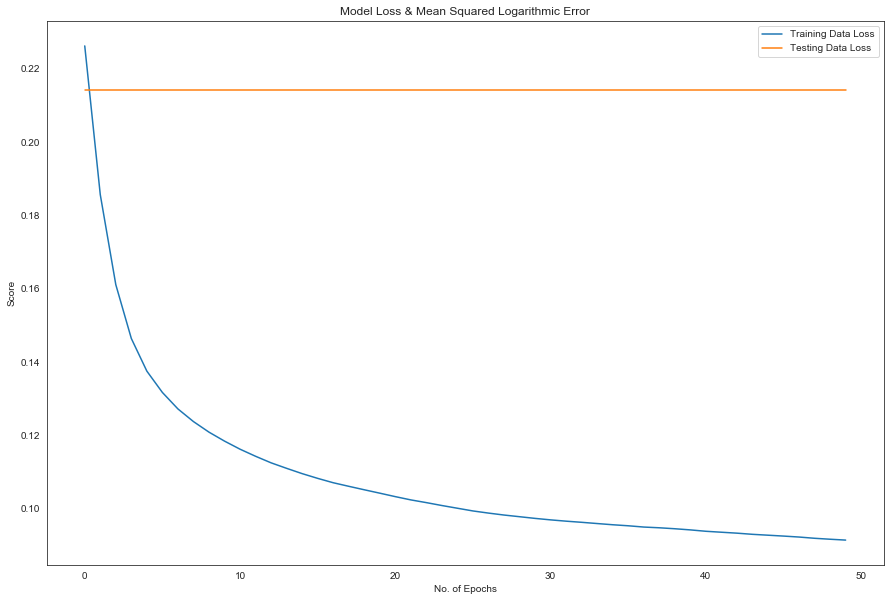

In [56]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot the MSLE for this model

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot the training data "loss" compared to the testing data "loss"
plt.plot(non_spend_history.history['loss'], label = "Training Data Loss")
plt.plot(non_spend_history.history['val_loss'], label = "Testing Data Loss")

## Provide some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Score")

## Provide a title and legend
plt.title("Model Loss & Mean Squared Logarithmic Error")
plt.legend()

## Show the graph
plt.show()

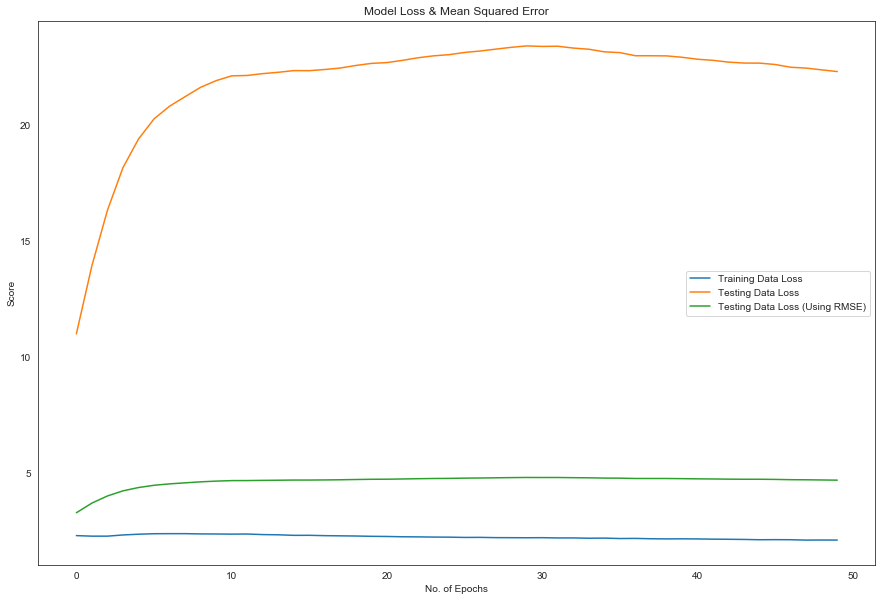

In [58]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot the training data "loss" compared to the testing data "loss"
plt.plot(non_spend_history.history['mse'], label = "Training Data Loss")
plt.plot(non_spend_history.history['val_mse'], label = "Testing Data Loss")

## Add more line for plotting the RMSE of testing data
plt.plot([sqrt(i) for i in non_spend_history.history['val_mse']], label = "Testing Data Loss (Using RMSE)")

## Provide some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Score")

## Provide a title and legend
plt.title("Model Loss & Mean Squared Error")
plt.legend(loc = "right")

## Show the graph
plt.show()

# D. Conclusions / Model Evaluation

## From the various models tested, it seems the best predictor of "Spending" is the model that was developed using Keras & Keras Tuner.  The reasoning behind this is that the model has less training data to use to learn, since we are removing a lot of the variance in the data by subsetting it to only include Purchases.

## In our original explorations, we were using training data that had a lot of 0.00 values in the Spending column (no purchase).  This meant that our modeling techniques were struggling with identifying the actual purchasing behavior because there were a lot of false positives.  The mining technique would see two sets of features that were similar but one would end with spend and one would not, and do a poor job assigning or estimating the spend of a customer.

## The basic idea is that there are two possible (and almost opposite) reasons for a data mining technique to not perform well.

## In the first case, we might have a model that is too complicated for the amount of data we have.  This situation, known as high variance, leads to model over-fitting.  We know that we are facing a high variance problem with this data set, and it is confirmed when we see that the training error is much lower than testing error.

## High variance problems can be addressed by reducing the number of features, and... yes, by increasing the number of data points, which we can't do here.

## These models have many features, as compared to our training examples, which is why we see the over-fitting in the first attempt of using Keras and Keras Tuner.

## However, we might have a model that is too simple to explain the data we have.  In this case, which is known as high bias, adding more data will not help.

## <span style="color:blue">  Here is the specific model selection and model testing steps.  The "best_model" would be declared the winner!

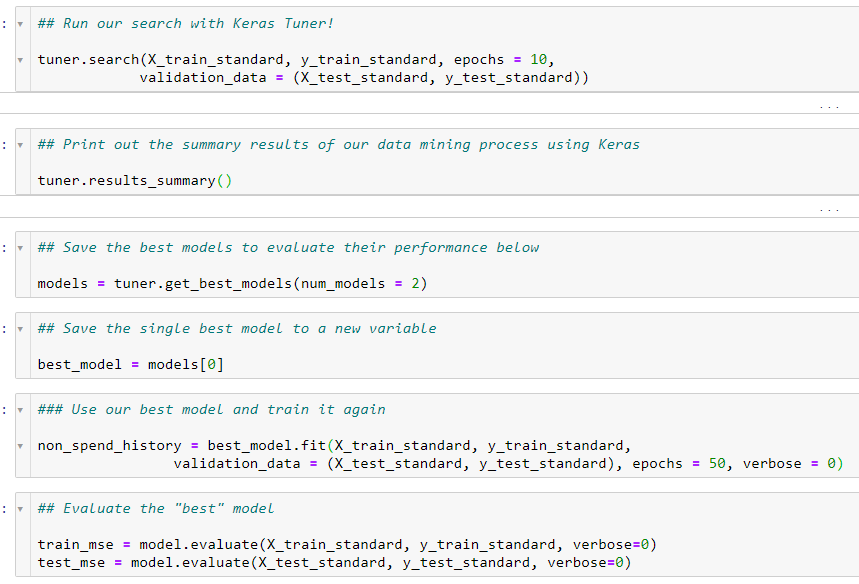

## <span style="color:blue">  I am highlighting two of the plots that were generated, that show a nice smoothing of the training data loss, which meant that the model was learning at a steady rate.  This is unlike the first attempt of building a model with Keras, where we saw a lot of uneven learning.

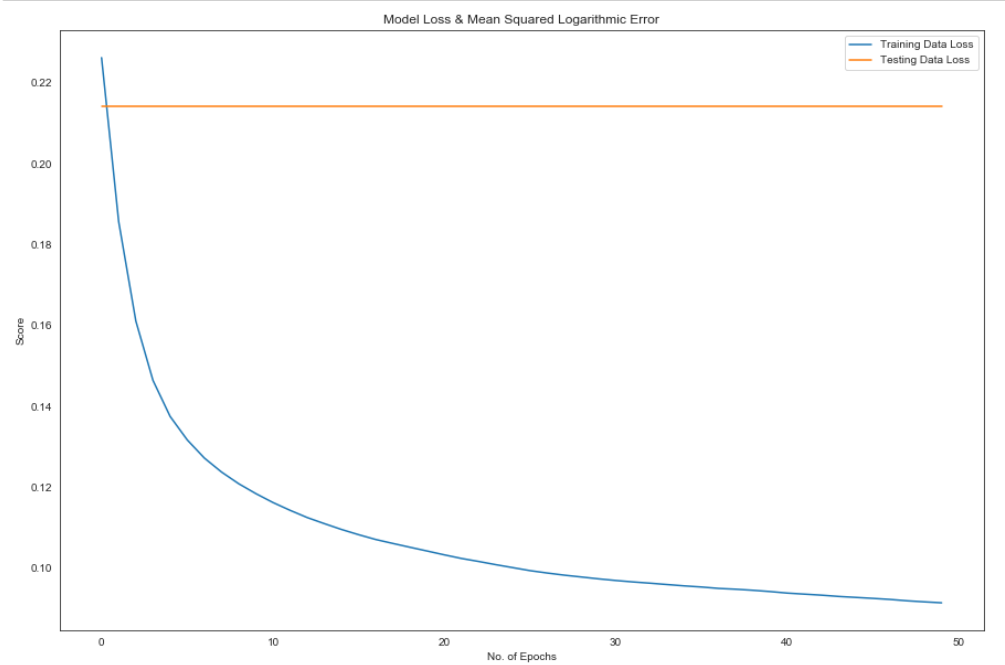

## <span style="color:blue"> When I look at the RMSE for the preferred regression model, it is much more stable and doesn't fluctuate quite as much when going through training cycles.  I am confident that this model is performing much better compared to my earlier attempts with the "out-of-box" regressors from `sklearn`.

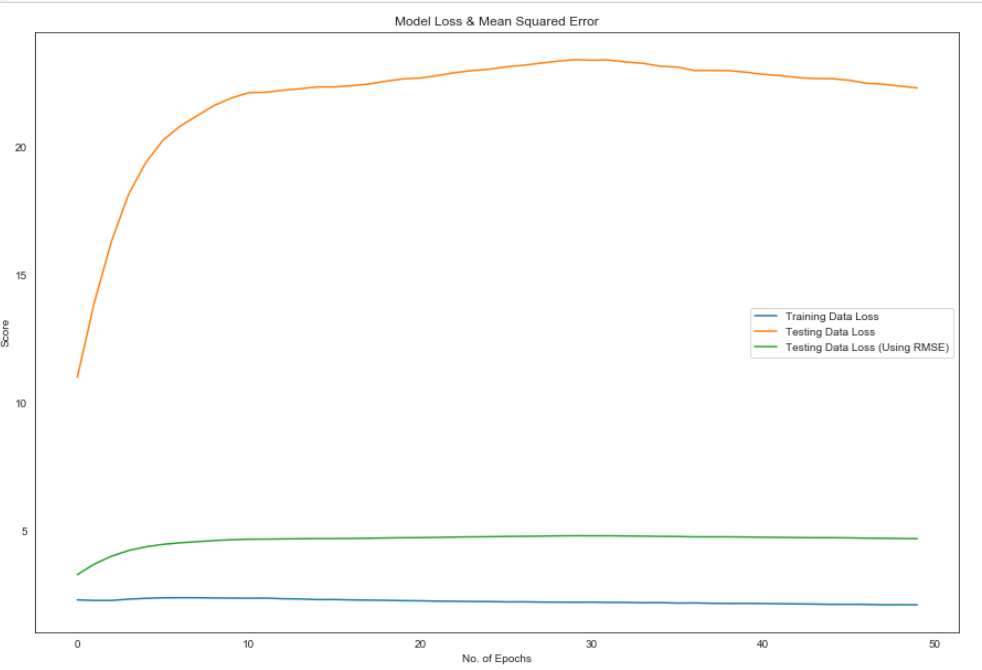

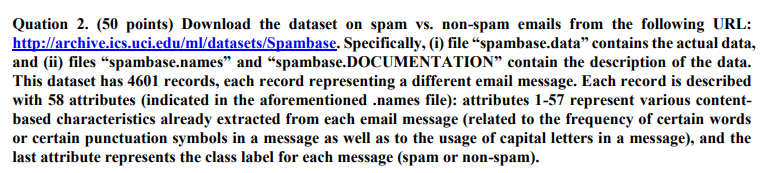

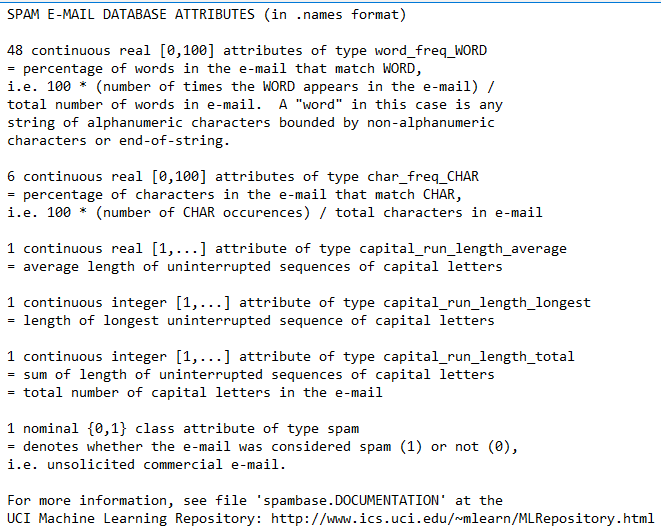

# A. Data pre-processing and pre-analysis

1.  Read in the data
2.  Explore the features and target variables to assess what parameters will need to be changed
3.  Prepare & transform data for data mining process

In [3]:
## Pull in all the column names based on the spam base documentation

colnames = ["word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", "word_freq_our", 
            "word_freq_over", "word_freq_remove", "word_freq_internet", "word_freq_order", "word_freq_mail", 
            "word_freq_receive", "word_freq_will", "word_freq_people", "word_freq_report", "word_freq_addresses", 
            "word_freq_free", "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit", 
            "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp", 
            "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs", 
            "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85", 
            "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct", 
            "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re", 
            "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_;", "char_freq_(", 
            "char_freq_[", "char_freq_!", "char_freq_$", "char_freq_#", "capital_run_length_average",
            "capital_run_length_longest", "capital_run_length_total", "spam"]

In [4]:
## Read in the file and save it as a dataframe

spambase_df = pd.read_csv("spambase.data", header = None, names = colnames)

In [5]:
## Look at the df to make sure it loaded correctly

spambase_df.tail()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
4596,0.31,0.0,0.62,0.0,0.00,0.31,0.0,0.0,0.0,0.0,...,0.000,0.232,0.0,0.000,0.0,0.0,1.142,3,88,0
4597,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.353,0.0,0.0,1.555,4,14,0
4598,0.30,0.0,0.30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.102,0.718,0.0,0.000,0.0,0.0,1.404,6,118,0
4599,0.96,0.0,0.00,0.0,0.32,0.00,0.0,0.0,0.0,0.0,...,0.000,0.057,0.0,0.000,0.0,0.0,1.147,5,78,0
4600,0.00,0.0,0.65,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.125,0.0,0.0,1.250,5,40,0


In [6]:
## Generate some summary statistics of the dataframe, just to see the distribution of the various attributes

spambase_df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [7]:
## Grab all columns as features except our target which is spam!

spam_feature_cols = spambase_df.columns[spambase_df.columns != "spam"]

In [8]:
spambase_df.spam.unique()

array([1, 0], dtype=int64)

In [9]:
spambase_df.groupby("spam")["word_freq_make"].count()

spam
0    2788
1    1813
Name: word_freq_make, dtype: int64

In [10]:
## View splits for the targets

total_obvs = spambase_df.groupby("spam")["word_freq_make"].count().sum()
total_non_spam = spambase_df.groupby("spam")["word_freq_make"].count()[0]
total_spam = spambase_df.groupby("spam")["word_freq_make"].count()[1]

## Uneven balanced classes
print("{} total non spam messages, \
     {} % of overall observations".format(total_non_spam, round(total_non_spam/total_obvs*100, 2)))
print("{} total spam messages, \
     {} % of overall observations".format(total_spam, round(total_spam/total_obvs*100, 2)))

2788 total non spam messages,      60.6 % of overall observations
1813 total spam messages,      39.4 % of overall observations


## We have unbalanced classes, so we will `stratify` our splits before developing the model.  For a classification task, this is chosen to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete data set.

In [12]:
## Grabbing all the features available
X = np.array(spambase_df[spam_feature_cols])

## Target variable
y = np.array(spambase_df["spam"])

In [13]:
## Split data training 70 % and testing 30%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

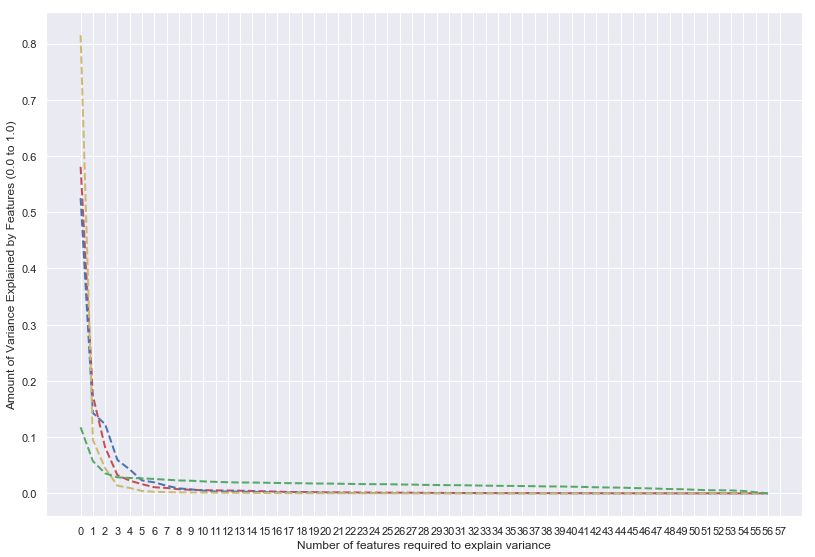

In [260]:
## We normalize our training and testing data PCA to work correctly
## We don't want to skew the results of the plot because some features are not on the same scale
## We perform this normalization AFTER splitting the data - again, so that we don't skew the training
## data with the testing data.

## Normalization is the process of scaling individual samples to have unit norm. This process can be useful 
## if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples.
X_train_norm = Normalizer(norm = "l1").fit_transform(X_train)
X_train_robust = RobustScaler().fit_transform(X_train)
X_train_power = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X_train)
X_train_standard = StandardScaler().fit_transform(X_train)

## Import PCA from sklearn
from sklearn.decomposition import PCA

## Initialize two new PCA instances, we'll use this to plot the training data using two different transformations
## Normalizer will likely be skewed by the outliers in each of the features being used
## Robust is going to transform feature values to be larger than the previous scalers and more importantly are approximately similar to original data
## PowerTransformer is a family of parametric, monotonic transformations that aim to map data from any distribution to as close to a Gaussian distribution 
## as possible in order to stabilize variance and minimize skewness.

pca = PCA()
pca_r = PCA()
pca_p = PCA()
pca_s = PCA()

## The goal of this plot is to determine what features need to be included in our models
## In the first few homeworks, we threw the kitchen sink at the models.  Here, we are going to be
## more refined in our analysis.

## Train the PCA instance using the normalized training data
pca.fit(X_train_norm)
pca_r.fit(X_train_robust)
pca_p.fit(X_train_power)
pca_s.fit(X_train_standard)

plt.figure(1, figsize=(15, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])

plt.plot(pca.explained_variance_ratio_, 'r--', linewidth = 2)
plt.plot(pca_r.explained_variance_ratio_, 'b--', linewidth = 2)
plt.plot(pca_p.explained_variance_ratio_, 'y--', linewidth = 2)
plt.plot(pca_s.explained_variance_ratio_, 'g--', linewidth = 2)

## Set plot labels
plt.xlabel('Number of features required to explain variance')
plt.ylabel('Amount of Variance Explained by Features (0.0 to 1.0)')

## Explicitly set the x-axis data so we can see where the drop-off is
plt.xticks(np.arange(0, 58, step=1))

## Show the graph!
plt.show()

## Only a very limited amount of features explain the variance in the data set.  For some of the classifiers, more information might actually lead to worse performance, either through over-fitting or not being able to converge successfully.

Feature ranking:
1. feature 51 (0.141203)
2. feature 23 (0.076135)
3. feature 6 (0.073537)
4. feature 52 (0.073031)
5. feature 54 (0.061571)
6. feature 55 (0.061143)
7. feature 56 (0.058942)
8. feature 15 (0.049227)
9. feature 20 (0.047997)
10. feature 22 (0.032252)


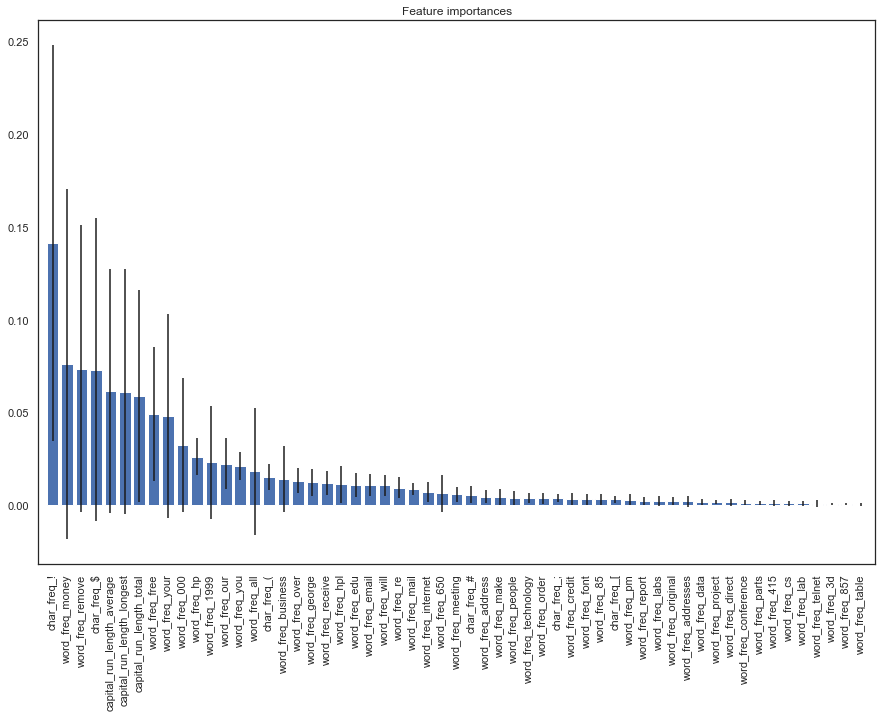

In [267]:
## SET A VARIABLE TO SWAP IN AND OUT BETWEEN THE DIFFERENT TRAINING INSTANCES

#Z = X_train_robust
#Z = X_train_norm
#Z = X_train_power
Z = X_train_standard

## Start with identifying the best features using a Random Forest classifier

## Create a new classifier
clf_rf_5 = ensemble.RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(Z, y_train)

## Save our importances to a variable
importances = clr_rf_5.feature_importances_

## Get the standard deviation for each feature
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

## Print the feature ranking
print("Feature ranking:")

## Print the top ten features, and their importance based on the Random Forest Classifier
for f in range(0, 10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


## Plot the feature importances of the Random Forest Regressor - to see this visually

## Set the plot size
plt.figure(1, figsize=(15, 10))

## Set the title
plt.title("Feature importances")

## Plot a graph using all of the normalized features
plt.bar(range(Z.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")

plt.xticks(range(Z.shape[1]), spam_feature_cols[indices], rotation=90)
plt.xlim([-1, Z.shape[1]])

## Show the graph!
plt.show()

## Similar to the analysis above, we don't see much need for many of these features; maybe only the first thirty or so will be important for performing this classification task.

## One final feature analysis, using a technique known as step-forward feature selection.

## Step forward feature selection starts with the evaluation of each individual feature, and selects that which results in the best performing selected algorithm model. What's the "best?" That depends entirely on the defined evaluation criteria (AUC, prediction accuracy, RMSE, etc.).  I am using accuracy as this is a classification task.

## Next, all possible combinations of the that selected feature and a subsequent feature are evaluated, and a second feature is selected, and so on, until the required predefined number of features is selected.

In [268]:
## Build RF classifier to use in feature selection
clf = ensemble.RandomForestClassifier()

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=6,
           forward=True, # Otherwise, this will be the backward selection 
           floating=False,
           n_jobs=10, # The number of CPUs to use for evaluating 
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train_standard, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  57 out of  57 | elapsed:    5.3s finished

[2019-10-31 16:08:16] Features: 1/6 -- score: 0.7779549202525267[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  56 out of  56 | elapsed:    3.0s finished

[2019-10-31 16:08:20] Features: 2/6 -- score: 0.8388206859921853[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  55 out of  55 | elapsed:    2.9s finished

[2019-10-31 16:08:23] Features: 3/6 -- score: 0.8680132610309345[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  54 out 

In [287]:
## Now we print out what feature columns of Linear Regressor picked out - we can use these to subset later
## We'll remember to grab these columns further along in the analysis
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[6, 24, 26, 45, 52, 55]


In [204]:
## Display the column names related to our "premier" features
for i in spambase_df.columns[feat_cols]:
    print(i)

word_freq_remove
word_freq_hp
word_freq_george
word_freq_edu
char_freq_$
capital_run_length_longest


## Based on this analysis, the top six features are presented above.

In [14]:
## Create new scaling object

sc = StandardScaler()

## Standardize dataset

X_train_standard = sc.fit_transform(X_train)
X_test_standard = sc.transform(X_test)

# B. Model Creation and Evaluation

1.  Create parameter grids for each model
2.  Used nested cross validation to determine the best model
3.  Tune the hyper parameters for the best model
4.  Evaluate the models on the testing data

## Here are the different models I will be using for my analysis for this classification problem

1. Logistic(linear) Classifier
2. k-Nearest Neighbors Classifier
3. Decision Tree Classifier
4. SVM Classifier
5. Ensemble/Gradient Boost CLassifier
6. Neural Network (Keras & KerasTuner)

In [135]:
######### SETTING UP PARAMETER GRIDS FOR THE DIFFERENT DATA MINING MODELS WE ARE GOING TO USE ############

## Set up a grid for the Logit Classifier
lc_p_grid = {"penalty": ["l2"],
            "C": [1, 5, 10, 50, 1000],
            "solver": ["liblinear"]}

## Set up a grid for kNN Classifier
## Going to use 1-30 neighbors, and two different distance calculations
knnc_p_grid = {"n_neighbors": list(range(1, 31)),
             "weights": ["uniform", "distance"]}

## Set up a grid for the DecisionTree Classifier
dtc_p_grid = {"criterion": ["gini"],
            "splitter": ["best"],
            "max_features": [15, 20, 25],
            "max_depth": [5, 10, 15]}

## Set up a grid for the Support Vector Classifier
svc_p_grid = {"C": [1, 10, 50, 1000],
              "gamma": [0.0001, 0.0005, 0.001, 0.005],
             "kernel": ["poly", "rbf"]}

## Set up a grid for GBoost Classifier
gbc_p_grid = {'loss': ["deviance"], 
                 'n_estimators': [100, 200, 300, 400, 500], 
                 'max_depth': [3, 4, 5],
                 'min_samples_split': [2, 4, 6],
                 'max_features': [5, 10],
                 'criterion': ["mse"],
                 'learning_rate': [0.01]}

In [136]:
## Set a number of trials to run for the models

num_trials = 20

## Empty arrays to store scores for classifier
nested_scores_lc = np.zeros(num_trials)
nested_scores_knnc = np.zeros(num_trials)
nested_scores_dtc = np.zeros(num_trials)
nested_scores_svc = np.zeros(num_trials)
nested_scores_gbc = np.zeros(num_trials)

In [137]:
## Create new regressors for each data mining technique

## Linear Regression
lc = linear_model.LogisticRegression()

## k-Nearest Neighbors
knnc = neighbors.KNeighborsClassifier()

## Decision Tree
dtc = tree.DecisionTreeClassifier()

## Support Vector Machine
svc = svm.SVC()

## Gradient Boost
gbc = ensemble.GradientBoostingClassifier()

In [303]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    lclass= GridSearchCV(estimator=lc, param_grid=lc_p_grid, cv=inner_cv)
    lclass.fit(X_train_standard, y_train)
    
    nested_score = cross_val_score(lclass, X = X_train_standard, y = y_train, cv = outer_cv)
    nested_scores_lc[i] = nested_score.mean()

In [305]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    knnclass= GridSearchCV(estimator=knnc, param_grid=knnc_p_grid, cv=inner_cv)
    knnclass.fit(X_train_standard, y_train)
    
    nested_score = cross_val_score(knnclass, X = X_train_standard, y = y_train, cv = outer_cv)
    nested_scores_knnr[i] = nested_score.mean()

KeyboardInterrupt: 

In [318]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    dtclass= GridSearchCV(estimator=dtc, param_grid=dtc_p_grid, cv=inner_cv)
    dtclass.fit(X_train_standard, y_train)
    
    nested_score = cross_val_score(dtreg, X = X_train_standard, y = y_train, cv = outer_cv)
    nested_scores_dtc[i] = nested_score.mean()

In [138]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    svclass= GridSearchCV(estimator=svc, param_grid=svc_p_grid, cv=inner_cv)
    svclass.fit(X_train_standard, y_train)
    
    nested_score = cross_val_score(svclass, X = X_train_standard, y = y_train, cv = outer_cv)
    nested_scores_svc[i] = nested_score.mean()

In [365]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Gradient Boost Classifier
    
    gbclass= GridSearchCV(estimator=gbc, param_grid=gbc_p_grid, cv=inner_cv)
    gbclass.fit(X_train_standard, y_train)
    
    nested_score = cross_val_score(gbclass, X = X_train_standard, y = y_train, cv = outer_cv)
    nested_scores_gbc[i] = nested_score.mean()

KeyboardInterrupt: 

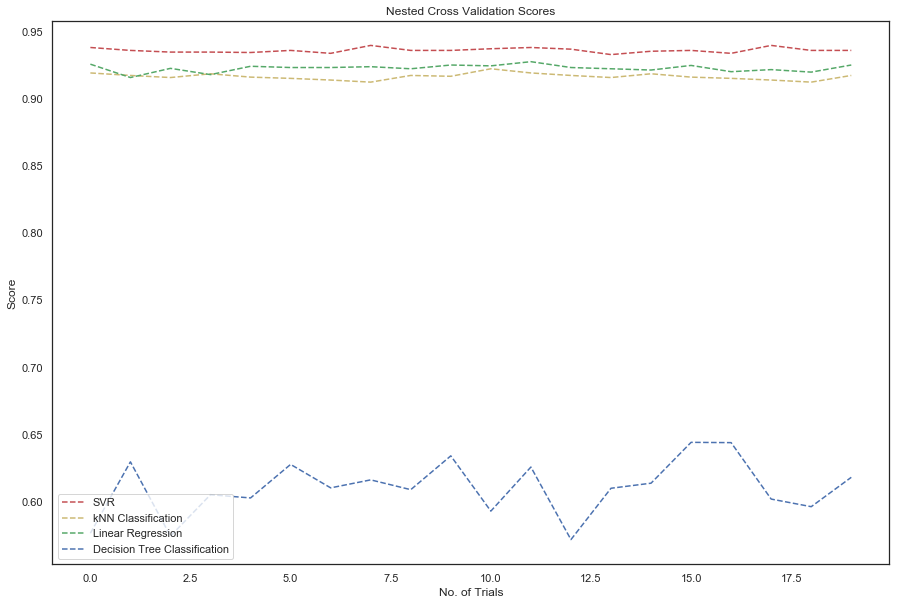

In [356]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(nested_scores_svc, 'r--', label = "SVR")
plt.plot(nested_scores_knnc, 'y--', label = "kNN Classification")
plt.plot(nested_scores_lc, 'g--', label = "Linear Regression")
plt.plot(nested_scores_dtc, 'b--', label = "Decision Tree Classification")
plt.plot(nested_scores_gbc, 'v--', label = "Gradient Boost")


## Give some labels
plt.xlabel("No. of Trials")
plt.ylabel("Score")

## Title and legend
plt.title("Nested Cross Validation Scores")
plt.legend(loc = 'lower left')

## Show the graph
plt.show()

## From our Cross Validation plot above, we see that a Support Vector Machine classifier performs the best at classifying spam email out of the different data mining procedures tested.

## Since it is pretty clear that this was an effective model, I will do further exploration using the best parameters selected by the nested cross validation process.

In [140]:
## Get our best params and their scores
print(svclass.best_params_)
print()

## Print out how well it performed using the best params
print(svclass.best_score_)

## save our best params so we can use them in our actual SVC model!
best_svc_params = svclass.best_params_

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

0.9347826086956522


In [147]:
## Initialize our DecisionTree classifier with the best params based on our GridSearch. 
svc_clf = svm.SVC(**best_svc_params, probability = True)

## Train the model (fit the data)
# 'fit' builds a decision tree from the training set (X, y).
svc_clf = svc_clf.fit(X_train_standard, y_train)

In [148]:
## Evaluate performance by cross-validation
scores = cross_val_score(svc_clf, X_train_standard, y_train, cv = 10)
print(scores)

print()

# The mean score and the 95% confidence interval of our scores:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.92569659 0.91925466 0.91925466 0.94099379 0.93167702 0.92546584
 0.93478261 0.94099379 0.95341615 0.93457944]

Accuracy: 0.93 (+/- 0.02)


In [149]:
## Create three empty lists to store my precision, recall, and average precision scores
precision, recall, average_precision = [], [], []

## Get probabilities for our labels
probas_ = svc_clf.predict_proba(X_test_standard)

In [156]:
## Create my false positive rate, true positive rate, and threshold using my test data
fpr, tpr, threholds = roc_curve(y_test, probas_[:, 1], pos_label = 1)

## Create precision and recall scores to plot with
precision_score, recall_score, _ = precision_recall_curve(y_test, probas_[:, 1])

## Calculate the overall AUC for the model
auc = np.trapz(tpr, fpr)

## Save the average precision for our model
avg_precision = average_precision_score(y_test, probas_[:, 1])

In [206]:
## Build a confusion matrix from our Support Vector Machine model - another assessment of performance

## Try to predict the outcomes on our test data
predicted = svc_clf.predict(X_test_standard)

## Compare that with our ACTUAL values from the test data set
matrix = confusion_matrix(y_test, predicted)
print(matrix)
print()

## Create a report to show our precision(accuracy), recall, and f1 for predictions
report = classification_report(y_test, predicted)
print(report)

[[798  39]
 [ 51 493]]

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       837
           1       0.93      0.91      0.92       544

    accuracy                           0.93      1381
   macro avg       0.93      0.93      0.93      1381
weighted avg       0.93      0.93      0.93      1381



## The AUC Curve is very, very close to being an almost perfect line.  This tells me this model is very effective at discovering and identifying spam emails.

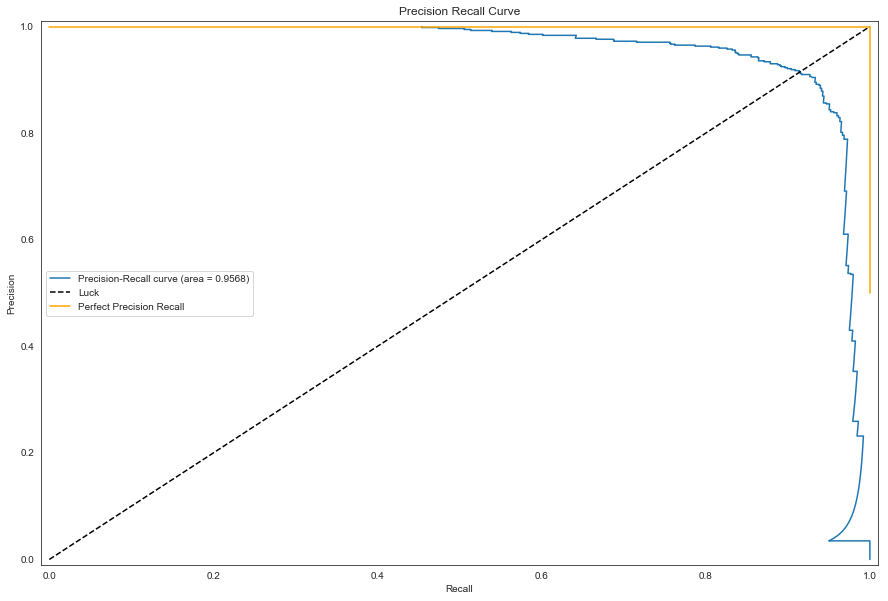

In [198]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Create a new figure to plot
plt.figure(figsize= (15, 10))

lw = 2


## Plot the model's Precision Recall Curve
plt.plot(precision_score, recall_score, linestyle = '-', label='Precision-Recall curve (area = {})'.format(round(avg_precision, 4)))

## Put in a line to demonstrate blind luck 
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--', label = 'Luck')

## Plot the perfect Precision Recall Line to see how well our SVM Classifier performed
plt.plot([0, 1], [1, 1], color = 'orange')
plt.plot([1, 1], [1, 0.5], color = 'orange', label = "Perfect Precision Recall")

## Set the limits so they start at zero
plt.ylim([-0.01, 1.01])
plt.xlim([-0.01, 1.01])
         
## Set labels for x and y
plt.xlabel('Recall')
plt.ylabel('Precision')

## Set a title and legend
plt.title('Precision Recall Curve')
plt.legend(loc = 'center left')

## Show the curve!
plt.show()

## Due to the slight class imbalance, I also generate a Precision-Recall curve; accuracy may not be an effective measure of model performance so it is good to just confirm the model is working as expected.

## Here we confirm our earlier observation that the model is performing extremely well, with an area of 0.9568.

## To reinforce and showcase how the model is performing at its classification task, I include two lines: one showing random luck (black) and a perfect Precision-Recall (orange). 

## I also want to investigate the cost for misclassification; it's not enough to make sure the model is working as expected; we want to penalize the model for mistakes (not too harshly) to make sure that we don't allow e-mails through that should not be allowed in.

##  I will punish false positives more harshly than false negative.  The reasoning behind this is if an email that *should* have been identified as spam get through, then it should be penalized vs. if the classifier misclassified a good email as spam.

## If a spam email gets through the filter, then any harmful software associated with that spam message may infect the user's computer down the line.

In [ ]:
## Initialize different thresholds and Costs that will be tied to those thresholds
thresholds = np.linspace(0, 1.0, num=21)

## Generate three generic Cost List for each matrix
Cost_List = np.linspace(0, 1.0, num=21)

## Build cost matrix for misidentifying spam
cost_matrix = np.array([[0, 1], [10, 0]])

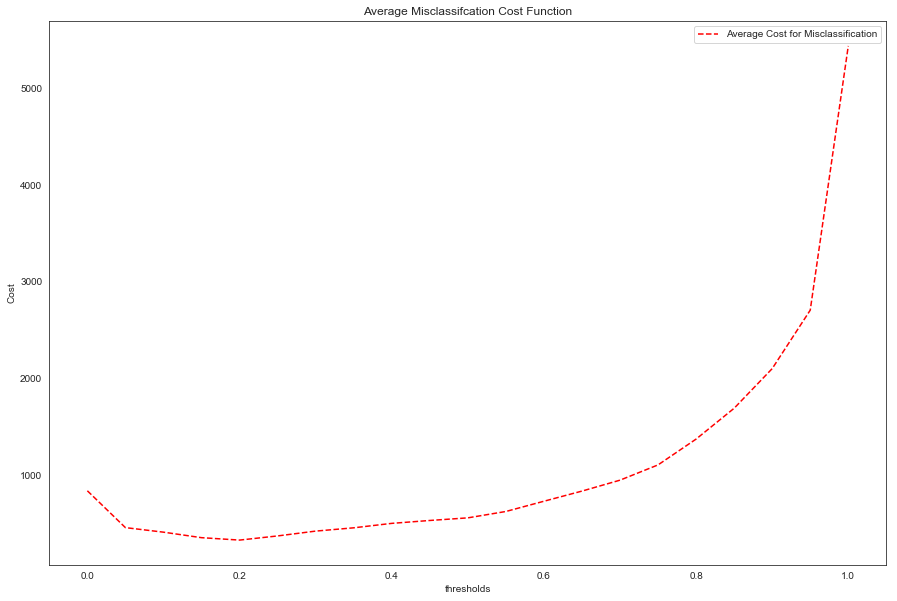

In [199]:
index = 0

for t in thresholds:
    
    predict_thre = np.where(probas_[:, 1] > t, 1, 0)  ## prediction based on the preset threshold
    clf_matrix = confusion_matrix(y_test, predict_thre)
    Cost_List[index] = clf_matrix[0][0]*cost_matrix[0][0] +clf_matrix[0][1]*cost_matrix[0][1] +clf_matrix[1][0]*cost_matrix[1][0] +clf_matrix[1][1]*cost_matrix[1][1]
    index+=1
    
## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot each Cost Line individually
plt.plot(thresholds, Cost_List, 'r--', label = "Average Cost for Misclassification")

## Give some labels
plt.xlabel("thresholds")
plt.ylabel("Cost")

## Title and legend
plt.title("Average Misclassifcation Cost Function")
plt.legend(loc = 'upper right')

## Show the Cost Matrix Analysis
plt.show()

## C. Use Keras and Keras Tuner to develop some classifiers

1.  Build the model function
2.  Build the hyper tuner function
3.  Tune the model and explore the data space to make predictions
4.  Assess the model performance.

In [15]:
## Just confirming the shape of the training data to know how many features we have
X_train_standard.shape

(3220, 57)

## Now that I can use Keras and hyper tuning, I will create a classifier using a similar process.

In [16]:
## First, we build a function to actually put together our model

def build_class_model(hp):
    
    ## Base layer
    cmodel = Sequential()
    
    ## Add first layer, test with 10 up to 22 features
    cmodel.add(layers.Dense(units = hp.Int ("units", 
                                          min_value = 20,
                                          max_value = 57,
                                          step = 2),
                          ## Use same initializer as model above
                          activation = "relu", kernel_initializer = "he_uniform"))
    
    ## Add target layer using linear regressor
    cmodel.add(layers.Dense(1, activation = "sigmoid"))
    
    ## Use different learning rates to test the model
    cmodel.compile(
    optimizer = keras.optimizers.SGD(
        hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])),
    
    
    ## Use same loss fucntion as before
    loss = "binary_crossentropy",
    
    ## Test using Accuracy
    
    metrics = ["accuracy", "binary_accuracy"])
    
    ## Return completed model
    return cmodel

In [99]:
## Build hyper tuner, will perform cross validation for us

### Use RandomSearch

classtuner = RandomSearch(

    ## Use model function from above
    build_class_model,
    
    ## What is objective function?  Using loss here
    objective = "val_accuracy",
    
    ## Set number of trials
    max_trials = 5,
    
    ## Number of executions
    executions_per_trial = 3,
    
    ## Set to short dir path
    directory = "C:\\"

)

In [22]:
classtuner.search(X_train_standard, y_train, epochs = 10,
                 validation_data = (X_test_standard, y_test))

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.6250 - binary_accuracy: 0.62 - ETA: 2s - loss: 0.8565 - accuracy: 0.4414 - binary_accuracy: 0.4414 - ETA: 1s - loss: 0.8521 - accuracy: 0.4428 - binary_accuracy: 0.44 - ETA: 0s - loss: 0.8269 - accuracy: 0.4636 - binary_accuracy: 0.46 - ETA: 0s - loss: 0.8334 - accuracy: 0.4611 - binary_accuracy: 0.46 - ETA: 0s - loss: 0.8260 - accuracy: 0.4605 - binary_accuracy: 0.46 - 1s 400us/sample - loss: 0.8271 - accuracy: 0.4584 - binary_accuracy: 0.4584 - val_loss: 0.8325 - val_accuracy: 0.4881 - val_binary_accuracy: 0.4881
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.4375 - binary_accuracy: 0.43 - ETA: 0s - loss: 0.8556 - accuracy: 0.4315 - binary_accuracy: 0.43 - ETA: 0s - loss: 0.8306 - accuracy: 0.4617 - binary_accuracy: 0.46 - ETA: 0s - loss: 0.8270 - accuracy: 0.4587 - binary_accuracy: 0.45 - ETA: 0s 

limit_output extension: Maximum message size of 10000 exceeded with 10070 characters

In [23]:
best_models = classtuner.get_best_models(num_models = 2)

In [24]:
top_model = best_models[0]

In [25]:
### Use our best model and reverify it against our test data

spam_history = top_model.fit(X_train_standard, y_train,
                validation_data = (X_test_standard, y_test), epochs = 50, verbose = 0)

In [26]:
train_acc = top_model.evaluate(X_train_standard, y_train, verbose=0)
test_acc = top_model.evaluate(X_test_standard, y_test, verbose=0)

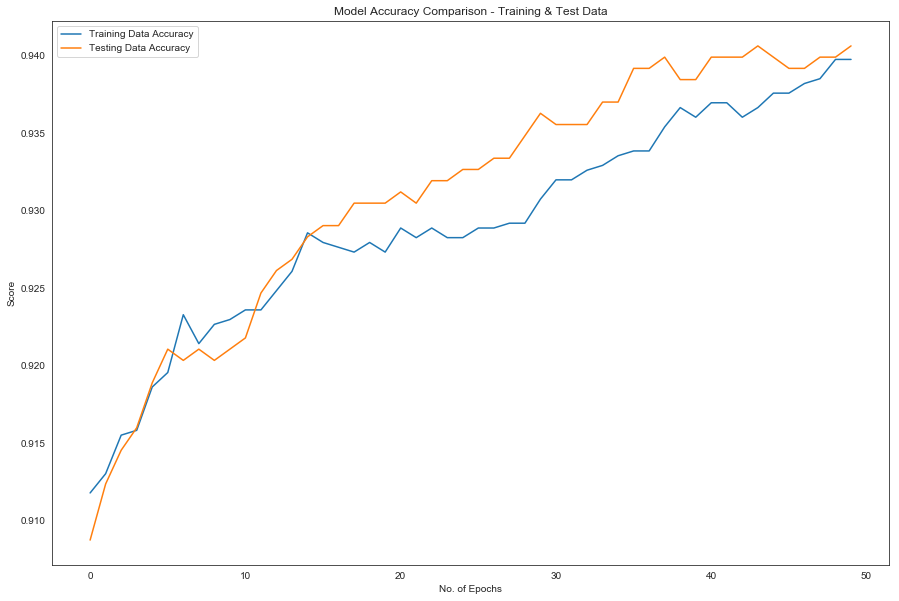

In [29]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(spam_history.history['accuracy'], label = "Training Data Accuracy")
plt.plot(spam_history.history['val_accuracy'], label = "Testing Data Accuracy")

## Give some labels and title
plt.xlabel("No. of Epochs")
plt.ylabel("Score")

## Title and legend
plt.title("Model Accuracy Comparison - Training & Test Data")
plt.legend()

## Show the graph
plt.show()

## Using `sklearn` metrics library, I can determine how well the model is performing by generating ROC, Precision, and Recall curves

In [30]:
## Create three empty lists to store my precision, recall, and average precision scores
precision, recall, average_precision = [], [], []

## Get probabilities for our labels
probas_ = top_model.predict_proba(X_test)

In [69]:
## Create my false positive rate, true positive rate, and threshold using my test data
fpr, tpr, threholds = roc_curve(y_test, probas_, pos_label = 1)

## Create precision and recall scores to plot with
precision_score, recall_score, _ = precision_recall_curve(y_test, probas_)

## Calculate the overall AUC for the model
auc = np.trapz(tpr, fpr)

## Save the average precision for our model
avg_precision = average_precision_score(y_test, probas_)

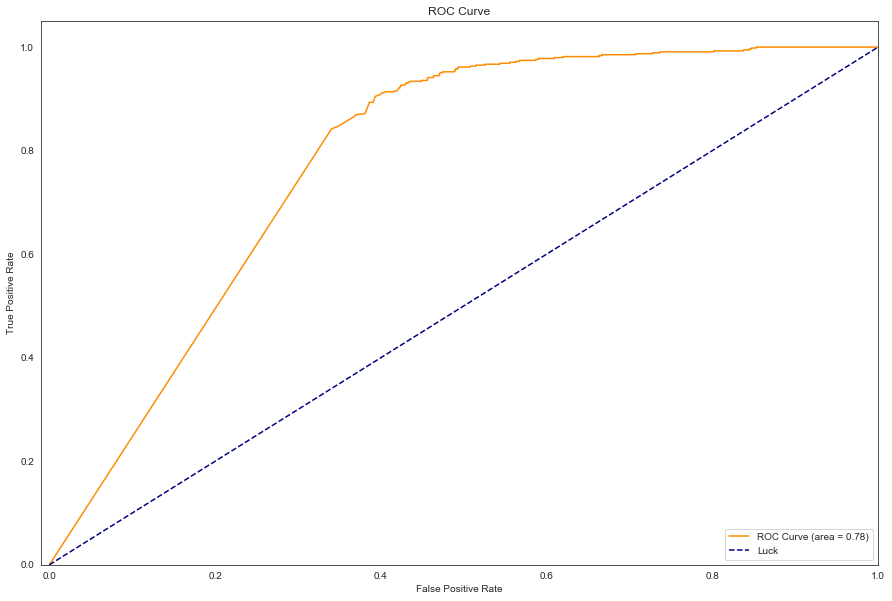

In [41]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Create a new figure to plot
plt.figure(figsize= (15, 10))

lw = 2

## Draw the line for my fpr and tpr
plt.plot(fpr, tpr, color = 'darkorange',
        label = 'ROC Curve (area = %0.2f)' % auc)

## Put in a line to demonstrate blind luck 
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--', label = 'Luck')

## Set the limits of the plot for better visualization
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
         
## Set labels for x and y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Set a title and legend
plt.title('ROC Curve')
plt.legend(loc = 'lower right')

## Show the curve!
plt.show()

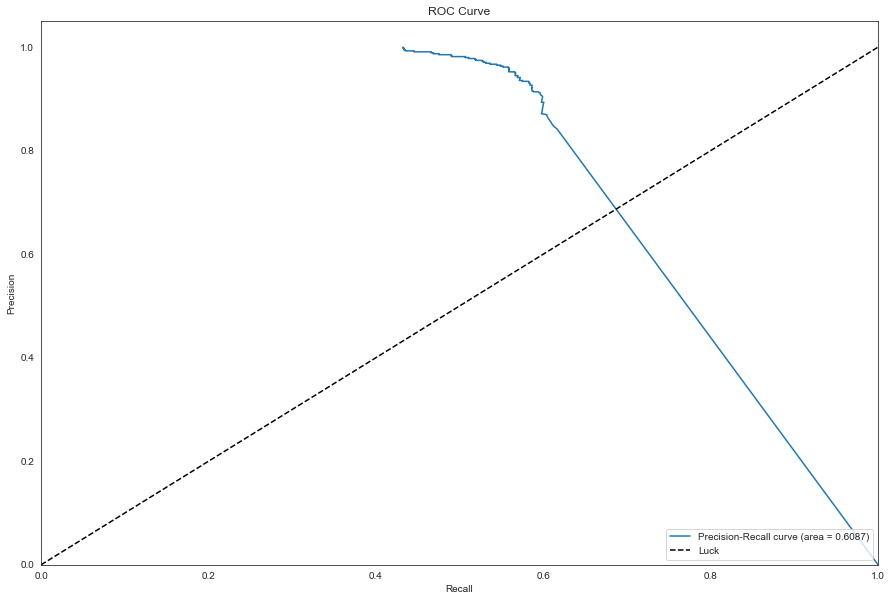

In [77]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Create a new figure to plot
plt.figure(figsize= (15, 10))

lw = 2


## Plot the model's Precision Recall Curve
plt.plot(precision_score, recall_score, label='Precision-Recall curve (area = {})'.format(round(avg_precision, 4)))

## Put in a line to demonstrate blind luck 
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--', label = 'Luck')

## Set the limits so they start at zero
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
         
## Set labels for x and y
plt.xlabel('Recall')
plt.ylabel('Precision')

## Set a title and legend
plt.title('ROC Curve')
plt.legend(loc = 'lower right')

## Show the curve!
plt.show()

## I will now be building a cost matrix and visualization for this; again this is to visualize and assess how the model is "punishing" mistakes.

In [61]:
## Initialize different thresholds and Costs that will be tied to those thresholds
thresholds = np.linspace(0, 1.0, num=21)

## Generate three generic Cost List for each matrix
Cost_List = np.linspace(0, 1.0, num=21)

## Build cost matrix for misidentifying spam
cost_matrix = np.array([[0, 1], [10, 0]])

In [64]:
## Show the cost matrix
cost_matrix

array([[ 0,  1],
       [10,  0]])

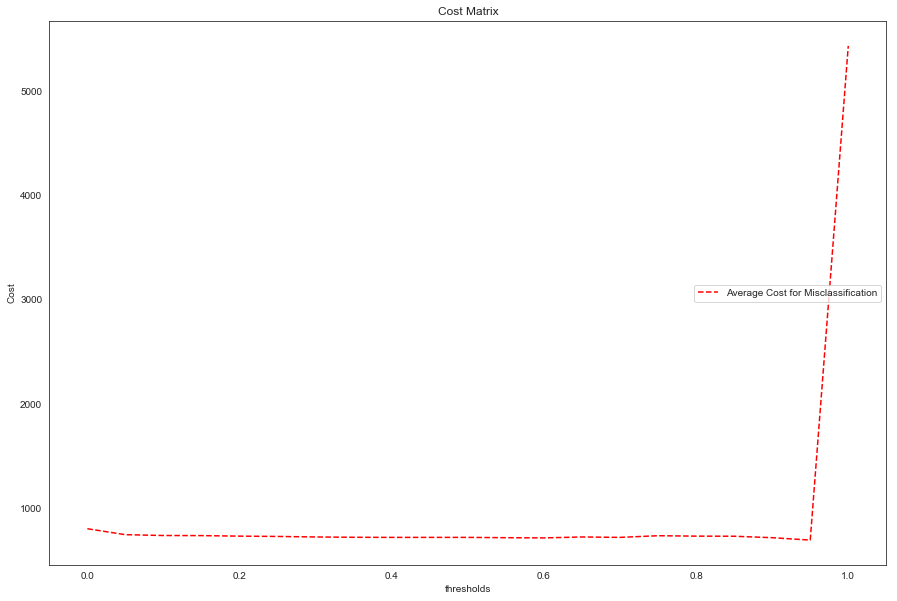

In [62]:
## Set the index to zero

index = 0

### Loop through our different thresholds and calculate the misclassification cost at each interval
for t in thresholds:
    
    predict_thre = np.where(probas_ > t, 1, 0)  ## prediction based on the preset threshold
    clf_matrix = confusion_matrix(y_test, predict_thre)
    Cost_List[index] = clf_matrix[0][0]*cost_matrix[0][0] +clf_matrix[0][1]*cost_matrix[0][1] +clf_matrix[1][0]*cost_matrix[1][0] +clf_matrix[1][1]*cost_matrix[1][1]
    index+=1
    
## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot each Cost Line individually
plt.plot(thresholds, Cost_List, 'r--', label = "Average Cost for Misclassification")

## Give some labels
plt.xlabel("thresholds")
plt.ylabel("Cost")

## Title and legend
plt.title("Cost Matrix")
plt.legend(loc = 'right')

## Show the Cost Matrix Analysis
plt.show()

## I am going to try one more model, using a Linear activator instead.  We'll see if we can improve the accuracy of the model.

In [120]:
## First, we build a function to actually put together our model - with change to use a linear activation instead

def build_class_model(hp):
    
    ## Base layer
    cmodel = Sequential()
    
    ## Add first layer, test with 30 up to 100 layers
    cmodel.add(layers.Dense(units = hp.Int ("units", 
                                          min_value = 30,
                                          max_value = 100,
                                          step = 2),
                          ## Use same initializer as model above
                          activation = "linear", kernel_initializer = "he_uniform"))
    
    ## Add target layer using linear regressor
    cmodel.add(layers.Dense(1, activation = "linear"))
    
    ## Use different learning rates to test the model
    cmodel.compile(
    optimizer = keras.optimizers.SGD(
        hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])),
    
    
    ## Use same loss fucntion as before
    loss = "binary_crossentropy",
    
    ## Test using Accuracy
    
    metrics = ["accuracy", "binary_accuracy"])
    
    ## Return completed model
    return cmodel

In [121]:
## Build hyper tuner, will perform cross validation for us

### Use RandomSearch

classtuner = RandomSearch(

    ## Use model function from above
    build_class_model,
    
    ## What is objective function?  Using loss here
    objective = "val_accuracy",
    
    ## Set number of trials
    max_trials = 5,
    
    ## Number of executions
    executions_per_trial = 3,
    
    ## Set to short dir path
    directory = "C:\\"

)

In [122]:
classtuner.search(X_train_standard, y_train, epochs = 10,
                 validation_data = (X_test_standard, y_test))

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 41s - loss: 0.6667 - accuracy: 0.5938 - binary_accuracy: 0.593 - ETA: 1s - loss: 0.6533 - accuracy: 0.5960 - binary_accuracy: 0.596 - ETA: 0s - loss: 0.6518 - accuracy: 0.6094 - binary_accuracy: 0.60 - ETA: 0s - loss: 0.6526 - accuracy: 0.6068 - binary_accuracy: 0.60 - ETA: 0s - loss: 0.6480 - accuracy: 0.6157 - binary_accuracy: 0.61 - 1s 266us/sample - loss: 0.6494 - accuracy: 0.6140 - binary_accuracy: 0.6140 - val_loss: 0.6507 - val_accuracy: 0.6119 - val_binary_accuracy: 0.6119
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.4688 - binary_accuracy: 0.46 - ETA: 0s - loss: 0.6469 - accuracy: 0.6175 - binary_accuracy: 0.61 - ETA: 0s - loss: 0.6442 - accuracy: 0.6263 - binary_accuracy: 0.62 - ETA: 0s - loss: 0.6481 - accuracy: 0.6174 - binary_accuracy: 0.61 - ETA: 0s - loss: 0.6484 - accuracy: 0.6159 - binary_accuracy: 0.61 - 0s 100us/

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 1:03 - loss: 0.7872 - accuracy: 0.3750 - binary_accuracy: 0.37 - ETA: 1s - loss: 0.7291 - accuracy: 0.4256 - binary_accuracy: 0.4256 - ETA: 0s - loss: 0.7011 - accuracy: 0.5022 - binary_accuracy: 0.50 - ETA: 0s - loss: 0.6844 - accuracy: 0.5471 - binary_accuracy: 0.54 - 1s 328us/sample - loss: 0.6797 - accuracy: 0.5593 - binary_accuracy: 0.5593 - val_loss: 0.6360 - val_accuracy: 0.6510 - val_binary_accuracy: 0.6510
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.6250 - binary_accuracy: 0.62 - ETA: 0s - loss: 0.6256 - accuracy: 0.6643 - binary_accuracy: 0.66 - ETA: 0s - loss: 0.6201 - accuracy: 0.6668 - binary_accuracy: 0.66 - 0s 75us/sample - loss: 0.6181 - accuracy: 0.6674 - binary_accuracy: 0.6674 - val_loss: 0.6000 - val_accuracy: 0.6843 - val_binary_accuracy: 0.6843
Epoch 3/10
3220/3220 [==============================] - ETA: 0s -

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 48s - loss: 0.7067 - accuracy: 0.4688 - binary_accuracy: 0.468 - ETA: 0s - loss: 0.6944 - accuracy: 0.5393 - binary_accuracy: 0.539 - ETA: 0s - loss: 0.6926 - accuracy: 0.5537 - binary_accuracy: 0.55 - 1s 252us/sample - loss: 0.6897 - accuracy: 0.5658 - binary_accuracy: 0.5658 - val_loss: 0.6785 - val_accuracy: 0.6046 - val_binary_accuracy: 0.6046
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.5625 - binary_accuracy: 0.56 - ETA: 0s - loss: 0.6824 - accuracy: 0.5958 - binary_accuracy: 0.59 - ETA: 0s - loss: 0.6767 - accuracy: 0.6006 - binary_accuracy: 0.60 - 0s 63us/sample - loss: 0.6726 - accuracy: 0.6012 - binary_accuracy: 0.6012 - val_loss: 0.6663 - val_accuracy: 0.6025 - val_binary_accuracy: 0.6025
Epoch 3/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.7188 - binary_accuracy: 0.71 - ETA: 0s - 

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 37s - loss: 0.6566 - accuracy: 0.5938 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.7723 - accuracy: 0.4492 - binary_accuracy: 0.449 - ETA: 0s - loss: 0.7541 - accuracy: 0.4497 - binary_accuracy: 0.44 - 1s 205us/sample - loss: 0.7448 - accuracy: 0.4531 - binary_accuracy: 0.4531 - val_loss: 0.7095 - val_accuracy: 0.4707 - val_binary_accuracy: 0.4707
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.6250 - binary_accuracy: 0.62 - ETA: 0s - loss: 0.6994 - accuracy: 0.4789 - binary_accuracy: 0.47 - ETA: 0s - loss: 0.6946 - accuracy: 0.4938 - binary_accuracy: 0.49 - 0s 65us/sample - loss: 0.6916 - accuracy: 0.5065 - binary_accuracy: 0.5065 - val_loss: 0.6775 - val_accuracy: 0.5489 - val_binary_accuracy: 0.5489
Epoch 3/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6562 - binary_accuracy: 0.65 - ETA: 0s - 

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 39s - loss: 0.6979 - accuracy: 0.5625 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6740 - accuracy: 0.5785 - binary_accuracy: 0.578 - ETA: 0s - loss: 0.6711 - accuracy: 0.5962 - binary_accuracy: 0.59 - 1s 219us/sample - loss: 0.6691 - accuracy: 0.6065 - binary_accuracy: 0.6065 - val_loss: 0.6622 - val_accuracy: 0.6097 - val_binary_accuracy: 0.6097
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6398 - accuracy: 0.6875 - binary_accuracy: 0.68 - ETA: 0s - loss: 0.6590 - accuracy: 0.6380 - binary_accuracy: 0.63 - ETA: 0s - loss: 0.6557 - accuracy: 0.6461 - binary_accuracy: 0.64 - 0s 67us/sample - loss: 0.6543 - accuracy: 0.6478 - binary_accuracy: 0.6478 - val_loss: 0.6513 - val_accuracy: 0.6488 - val_binary_accuracy: 0.6488
Epoch 3/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.6250 - binary_accuracy: 0.62 - ETA: 0s - 

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 37s - loss: 0.7037 - accuracy: 0.5625 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6951 - accuracy: 0.5961 - binary_accuracy: 0.596 - ETA: 0s - loss: 0.6928 - accuracy: 0.5869 - binary_accuracy: 0.58 - 1s 204us/sample - loss: 0.6876 - accuracy: 0.5885 - binary_accuracy: 0.5885 - val_loss: 0.6758 - val_accuracy: 0.5844 - val_binary_accuracy: 0.5844
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.5000 - binary_accuracy: 0.50 - ETA: 0s - loss: 0.6705 - accuracy: 0.5945 - binary_accuracy: 0.59 - ETA: 0s - loss: 0.6705 - accuracy: 0.5849 - binary_accuracy: 0.58 - 0s 58us/sample - loss: 0.6728 - accuracy: 0.5786 - binary_accuracy: 0.5786 - val_loss: 0.6646 - val_accuracy: 0.5858 - val_binary_accuracy: 0.5858
Epoch 3/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.5625 - binary_accuracy: 0.56 - ETA: 0s - 

Train on 3220 samples, validate on 1381 samples
Epoch 1/10
3220/3220 [==============================] - ETA: 37s - loss: 0.7316 - accuracy: 0.4688 - binary_accuracy: 0.468 - ETA: 0s - loss: 0.7599 - accuracy: 0.4199 - binary_accuracy: 0.419 - ETA: 0s - loss: 0.7643 - accuracy: 0.3947 - binary_accuracy: 0.39 - 1s 216us/sample - loss: 0.7630 - accuracy: 0.3938 - binary_accuracy: 0.3938 - val_loss: 0.7671 - val_accuracy: 0.3845 - val_binary_accuracy: 0.3845
Epoch 2/10
3220/3220 [==============================] - ETA: 0s - loss: 0.7992 - accuracy: 0.4375 - binary_accuracy: 0.43 - ETA: 0s - loss: 0.7582 - accuracy: 0.3971 - binary_accuracy: 0.39 - ETA: 0s - loss: 0.7576 - accuracy: 0.3898 - binary_accuracy: 0.38 - 0s 60us/sample - loss: 0.7547 - accuracy: 0.3953 - binary_accuracy: 0.3953 - val_loss: 0.7590 - val_accuracy: 0.3838 - val_binary_accuracy: 0.3838
Epoch 3/10
3220/3220 [==============================] - ETA: 0s - loss: 0.8158 - accuracy: 0.2188 - binary_accuracy: 0.21 - ETA: 0s - 

Epoch 9/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6102 - accuracy: 0.6250 - binary_accuracy: 0.62 - ETA: 0s - loss: 0.6641 - accuracy: 0.6060 - binary_accuracy: 0.60 - ETA: 0s - loss: 0.6551 - accuracy: 0.6171 - binary_accuracy: 0.61 - ETA: 0s - loss: 0.6534 - accuracy: 0.6204 - binary_accuracy: 0.62 - 0s 89us/sample - loss: 0.6519 - accuracy: 0.6239 - binary_accuracy: 0.6239 - val_loss: 0.6508 - val_accuracy: 0.6249 - val_binary_accuracy: 0.6249
Epoch 10/10
3220/3220 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.5938 - binary_accuracy: 0.59 - ETA: 0s - loss: 0.6353 - accuracy: 0.6463 - binary_accuracy: 0.64 - ETA: 0s - loss: 0.6403 - accuracy: 0.6431 - binary_accuracy: 0.64 - ETA: 0s - loss: 0.6490 - accuracy: 0.6254 - binary_accuracy: 0.62 - 0s 83us/sample - loss: 0.6502 - accuracy: 0.6252 - binary_accuracy: 0.6252 - val_loss: 0.6492 - val_accuracy: 0.6249 - val_binary_accuracy: 0.6249
Train on 3220 samples, validate on 1381 samples
E

In [123]:
best_linear_model = classtuner.get_best_models(num_models = 1)

best_linear_model = best_linear_model[0]

In [124]:
### Use our best model and reverify it against our test data

spam_linear_history = best_linear_model.fit(X_train_standard, y_train,
                validation_data = (X_test_standard, y_test), epochs = 50, verbose = 0)

In [125]:
train_acc = best_linear_model.evaluate(X_train_standard, y_train, verbose=0)
test_acc = best_linear_model.evaluate(X_test_standard, y_test, verbose=0)

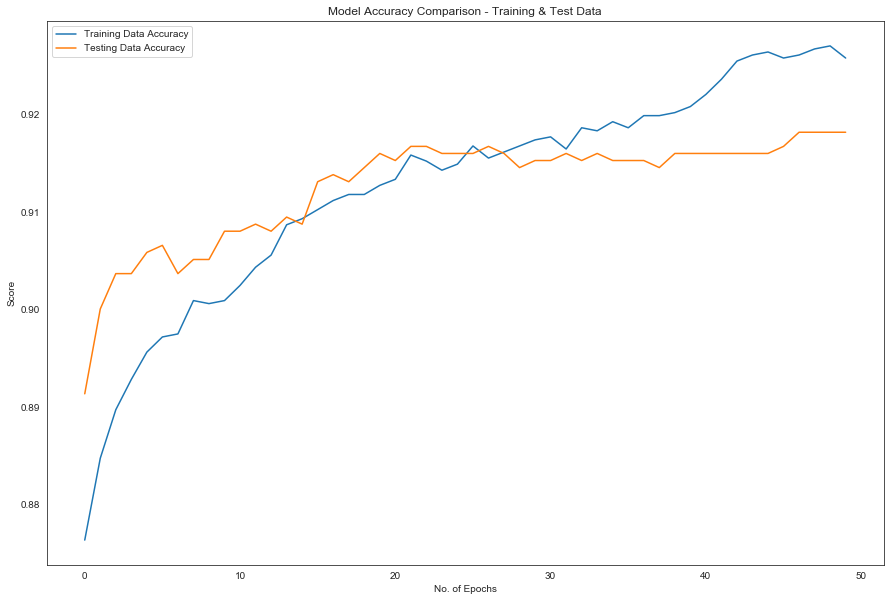

In [126]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(spam_linear_history.history['accuracy'], label = "Training Data Accuracy")
plt.plot(spam_linear_history.history['val_accuracy'], label = "Testing Data Accuracy")

## Give some labels and title
plt.xlabel("No. of Epochs")
plt.ylabel("Score")

## Title and legend
plt.title("Model Accuracy Comparison - Training & Test Data")
plt.legend()

## Show the graph
plt.show()

In [127]:
## Create three empty lists to store my precision, recall, and average precision scores
precision, recall, average_precision = [], [], []

## Get probabilities for our labels
probas_ = best_linear_model.predict_proba(X_test)

In [128]:
## Create my false positive rate, true positive rate, and threshold using my test data
fpr, tpr, threholds = roc_curve(y_test, linear_probas_, pos_label = 1)

## Create precision and recall scores to plot with
precision_score, recall_score, _ = precision_recall_curve(y_test, probas_)

## Calculate the overall AUC for the model
auc = np.trapz(tpr, fpr)

## Save the average precision for our model
avg_precision = average_precision_score(y_test, probas_)

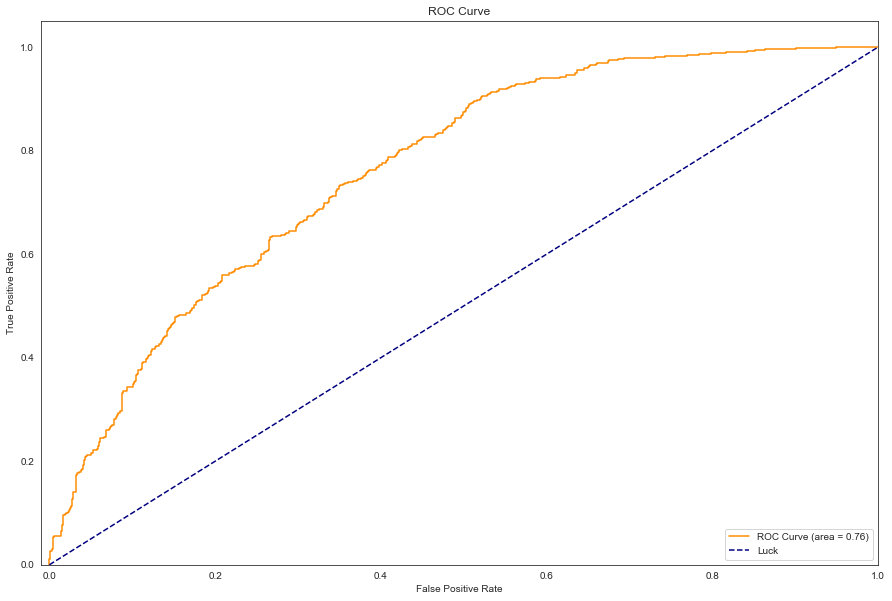

In [129]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Create a new figure to plot
plt.figure(figsize= (15, 10))

lw = 2

## Draw the line for my fpr and tpr
plt.plot(fpr, tpr, color = 'darkorange',
        label = 'ROC Curve (area = %0.2f)' % auc)

## Put in a line to demonstrate blind luck 
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--', label = 'Luck')

## Set the limits of the plot for better visualization
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
         
## Set labels for x and y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Set a title and legend
plt.title('ROC Curve')
plt.legend(loc = 'lower right')

## Show the curve!
plt.show()

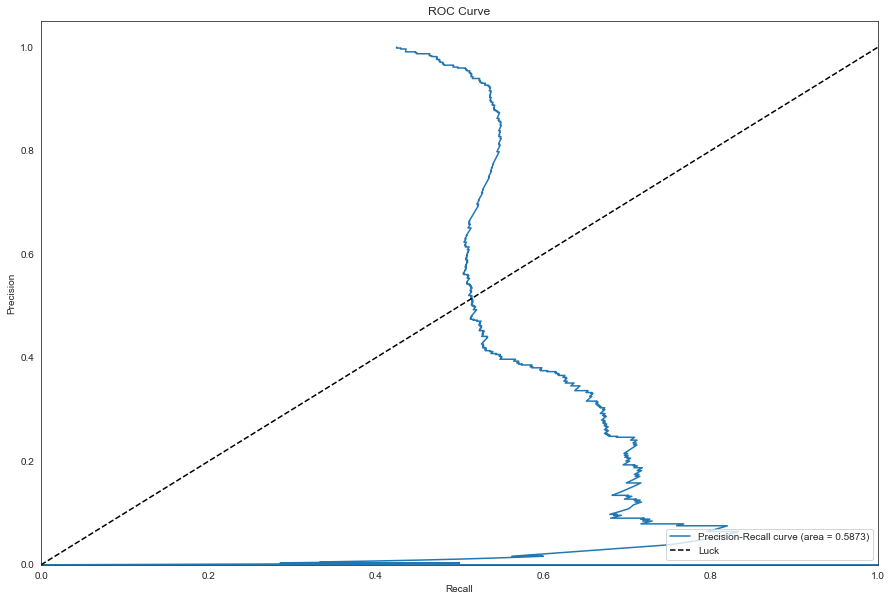

In [130]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Create a new figure to plot
plt.figure(figsize= (15, 10))

lw = 2


## Plot the model's Precision Recall Curve
plt.plot(precision_score, recall_score, label='Precision-Recall curve (area = {})'.format(round(avg_precision, 4)))

## Put in a line to demonstrate blind luck 
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--', label = 'Luck')

## Set the limits so they start at zero
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
         
## Set labels for x and y
plt.xlabel('Recall')
plt.ylabel('Precision')

## Set a title and legend
plt.title('ROC Curve')
plt.legend(loc = 'lower right')

## Show the curve!
plt.show()

## Interesting!  The classifier behaved pretty similarly to the one generated above but the precision-recall curve is wildly different, and converges very strangely.  I would be extremely cautious using this model.

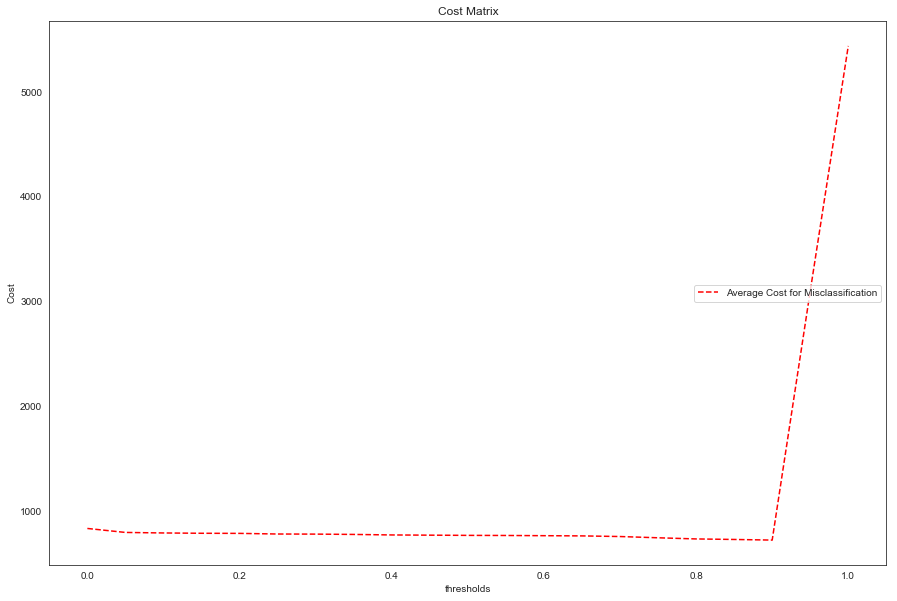

In [132]:
index = 0

for t in thresholds:
    
    predict_thre = np.where(probas_ > t, 1, 0)  ## prediction based on the preset threshold
    clf_matrix = confusion_matrix(y_test, predict_thre)
    Cost_List[index] = clf_matrix[0][0]*cost_matrix[0][0] +clf_matrix[0][1]*cost_matrix[0][1] +clf_matrix[1][0]*cost_matrix[1][0] +clf_matrix[1][1]*cost_matrix[1][1]
    index+=1
    
## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot each Cost Line individually
plt.plot(thresholds, Cost_List, 'r--', label = "Average Cost for Misclassification")

## Give some labels
plt.xlabel("thresholds")
plt.ylabel("Cost")

## Title and legend
plt.title("Cost Matrix")
plt.legend(loc = 'right')

## Show the Cost Matrix Analysis
plt.show()

## The average cost of misclassification is pretty similar to our first Keras model.

# D. Conclusions / Model Evaluation

## <span style="color:blue"> Based on the analysis completed, my selection for the best identifier for this classification would be using a Support Vector Machine with these hyper parameters tuned:

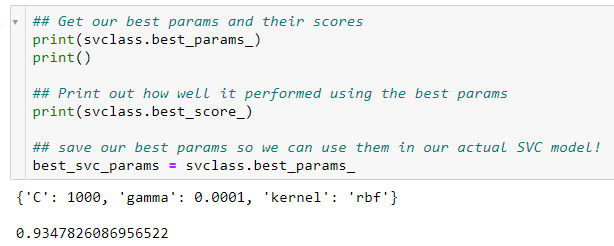

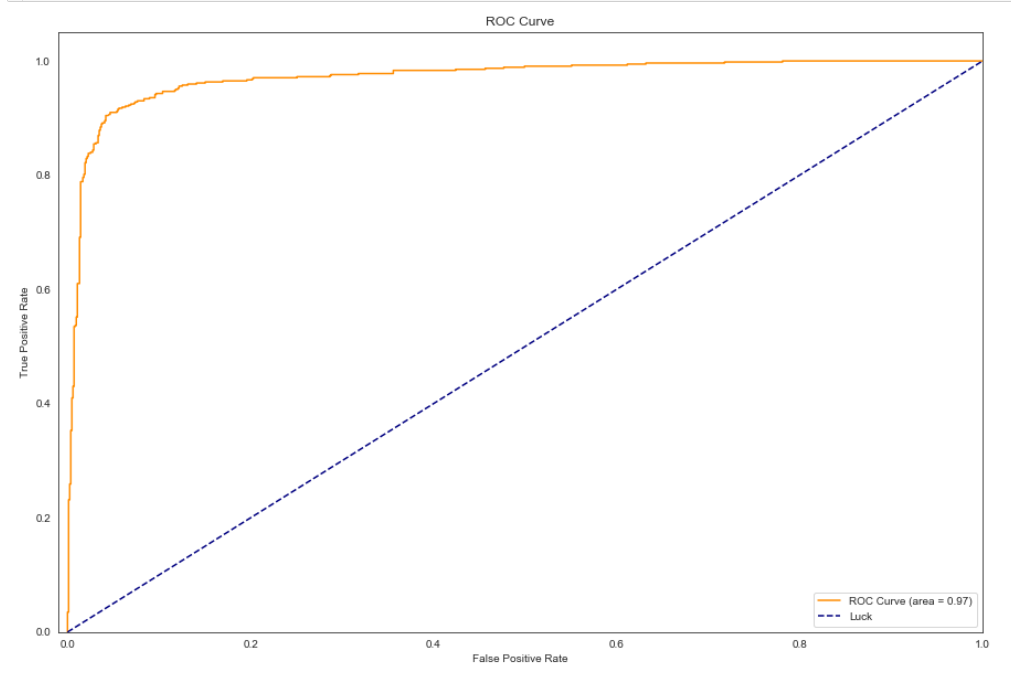

## <span style="color:blue"> As we are dealing with unbalanced classes, this metric is not enough to make sure the model is accurate.  That's where a precision recall curve helps accurately determine model performance.

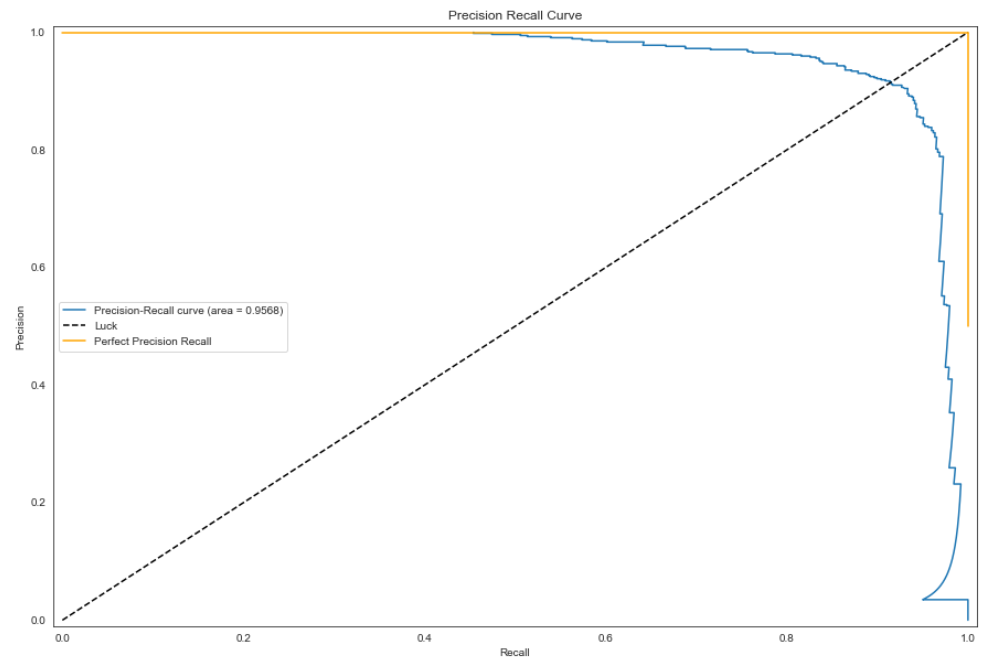

## <span style="color:blue"> With the model's performance, as compared to random luck / guessing, and being a perfect world, it does very well.  When you compare this Precision-Recall curves to the ones generated by the classifier we created with Keras, it is a much better performing classifier.

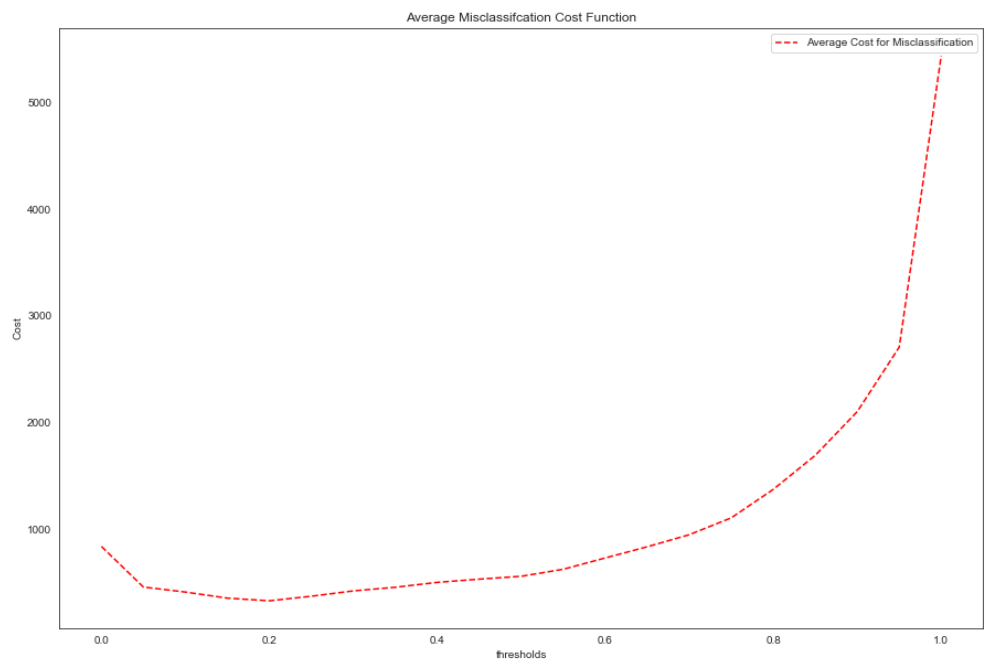

## <span style="color:blue"> As it gets closer to identifying spam, the "preferred" Support Vector Machine classifier punishes mistakes more harshly, which is the behavior that I was hoping for.  Again, the idea is to punish misidentifying potential spam as not spam, so we want the model to be accurate here.

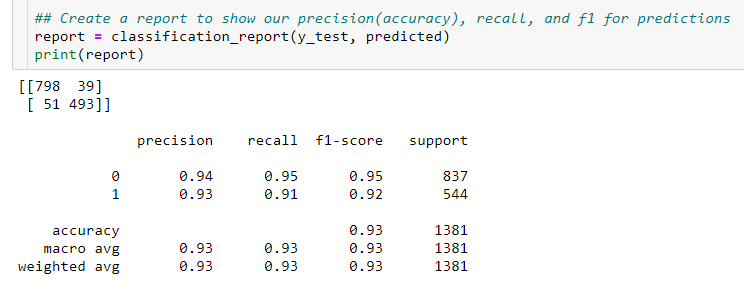

## <span style="color:blue"> The support vector machine does well at both classification tasks, and might be improved with additional data to learn and refine its search.

## <span style="color:red"> Thank you for reading my analysis!